# Network psicologici {#sec-networks}

**Prerequisiti**

- Leggere il capitolo *Psychological Networks: A Modern Approach to Analysis of Learning and Complex Learning Processes* del testo di @saqr2024learning.

**Concetti e Competenze Chiave**

  - Definizione e utilizzo delle reti per modellare le interazioni tra variabili psicologiche.
  - Stima delle reti con metodi come le correlazioni parziali regolarizzate.
  - Rappresentazione grafica delle connessioni tra nodi e interpretazione dei pesi degli archi.
  - Confronto delle strutture di rete (es. tra gruppi o contesti) utilizzando metodi statistici come il *Network Comparison Test (NCT)*.
  - Valutazione della stabilità dei pesi degli archi tramite *bootstrapping*.
  - Verifica dell'accuratezza delle misure di centralità con il *case dropping test*.
  - Interpretazione come misura della stabilità delle centralità, valutata in base alla correlazione residua con il campione ridotto.

**Preparazione del Notebook**

In [1]:
here::here("code", "_common.R") |> source()

# Load packages
if (!requireNamespace("pacman")) install.packages("pacman")
pacman::p_load(
    rio, bootnet, networktools, NetworkToolbox, NetworkComparisonTest, qgraph, mgm, matrixcalc
)

## Introduzione

Questo capitolo costituisce un semplice riassunto semplificato del capitolo *Psychological Networks: A Modern Approach to Analysis of Learning and Complex Learning Processes* del testo di @saqr2024learning.

## La Network Analysis

Come messo in evidenza da @saqr2024learning, l'analisi delle reti rappresenta un potente strumento per i ricercatori, utile per mappare relazioni, individuare connessioni e scoprire cluster o comunità tra componenti interagenti. Per questo motivo, è diventata una delle metodologie più importanti per comprendere i sistemi complessi. In psicologia, l'analisi delle reti ha acquisito sempre più rilevanza, non solo per lo studio delle interazioni sociali, ma anche per esplorare sistemi più astratti come i processi cognitivi, emotivi o comportamentali. In questo contesto, si utilizzano le reti probabilistiche, un tipo di rete in cui i nodi rappresentano variabili (come indicatori di costrutti psicologici o punteggi di scala) e gli archi esprimono l'entità delle associazioni probabilistiche tra queste variabili.

Un esempio particolarmente rilevante in psicologia è costituito dai **Gaussian Graphical Models (GGM)**, nei quali i nodi possono rappresentare costrutti come emozioni, comportamenti, atteggiamenti o tratti psicologici, e gli archi riflettono le correlazioni parziali tra questi nodi. Una correlazione parziale misura la relazione tra due variabili controllando o aggiustando per l'effetto di tutte le altre variabili nella rete, il cosiddetto principio del *ceteris paribus*. 

Ad esempio, immaginiamo di modellare una rete psicologica in cui i nodi rappresentano motivazione, successo accademico, coinvolgimento, autoregolazione e benessere. Se osserviamo un arco che connette benessere e successo accademico, ciò indica che il benessere è associato al successo accademico indipendentemente dagli effetti di motivazione, coinvolgimento e autoregolazione (le altre variabili del sistema). Al contrario, l'assenza di un arco tra due nodi suggerisce che le due variabili sono condizionalmente indipendenti, una volta considerati gli effetti di tutte le altre variabili nella rete.

Le reti psicologiche offrono anche strumenti rigorosi per valutare l'accuratezza delle stime, la forza degli archi e le misure di centralità attraverso tecniche come il *bootstrapping*. Inoltre, è possibile simulare la variabilità campionaria per stimare la replicabilità attesa delle reti studiate, aumentando la robustezza dei risultati.

Per fare un esempio pratico, consideriamo una rete che rappresenta le relazioni tra emozioni negative (ansia, tristezza, rabbia), pensieri disfunzionali e strategie di coping. Se identifichiamo un'interazione tra ansia e pensieri disfunzionali, possiamo interpretarla come un'indicazione che l'ansia è strettamente legata ai pensieri disfunzionali, al netto dell'effetto di altre variabili come tristezza, rabbia e coping. Questo tipo di analisi permette non solo di comprendere le interazioni tra i vari componenti, ma anche di identificare potenziali bersagli per interventi psicologici, come rafforzare il coping per ridurre l'impatto delle emozioni negative sui pensieri disfunzionali.

## Tutorial con R

In questa sezione presentiamo un tutorial passo-passo su come utilizzare le reti psicologiche applicandole a dati raccolti in indagini trasversali, così come presentato da @saqr2024learning. Il dataset utilizzato contiene le risposte di 6071 studenti a un questionario che indaga le caratteristiche psicologiche legate al loro benessere durante la pandemia di COVID-19, condotto in Finlandia e Austria. 

Le domande del questionario riguardano i bisogni psicologici fondamentali degli studenti (relazionalità, autonomia e competenza percepita), l’apprendimento autoregolato, le emozioni positive e la motivazione intrinseca verso l’apprendimento. Inoltre, il dataset include variabili demografiche come paese di residenza, genere ed età.

Nel tutorial, mostreremo come costruire e visualizzare una rete che rappresenti le relazioni tra le diverse caratteristiche psicologiche. Successivamente, interpreteremo e valuteremo queste relazioni e confronteremo le differenze nelle reti tra gruppi demografici. Questo approccio consente di esplorare in modo visivo e quantitativo i collegamenti tra i costrutti psicologici, identificando eventuali differenze tra le categorie demografiche.

## Importazione e Preparazione dei Dati

Il primo passo consiste nell'importare i dati e prepararli, rimuovendo le risposte mancanti o incomplete. 

In [2]:
URL <- ("https://raw.githubusercontent.com/lamethods/data/main/11_universityCovid/data.sav") 
df <- import(URL) |>
    drop_na()

Per rappresentare ciascun costrutto misurato dal questionario, combiniamo tutte le colonne relative agli item dello stesso costrutto calcolando la media delle risposte. Il seguente codice calcola la media per ogni costrutto sommando e mediando tutti gli item associati:

In [3]:
aggregated <- df |> rowwise() |> mutate(
    Competence = rowMeans(cbind
    (comp1.rec , comp2.rec, comp3.rec),
    na.rm = T),
    Autonomy = rowMeans(cbind
    (auto1.rec , auto2.rec, auto3.rec),
    na.rm = T),
    Motivation = rowMeans(cbind
    (lm1.rec , lm2.rec, lm3.rec),
    na.rm = T),
    Emotion = rowMeans(cbind
    (pa1.rec , pa2.rec, pa3.rec),
    na.rm = T),
    Relatedness = rowMeans(cbind
    (sr1.rec , sr2.rec, sr3.rec),
    na.rm = T),
    SRL = rowMeans(cbind
    (gp1.rec , gp2.rec, gp3.rec),
    na.rm = T)
)

Dopo aver creato queste nuove colonne, possiamo conservare solo quelle appena generate. Inoltre, creiamo dei sottoinsiemi di dati in base al genere (un dataset per i maschi e uno per le femmine) e al paese (un dataset per l'Austria e un altro per la Finlandia). Utilizzeremo questi dataset successivamente per confronti tra generi e paesi.

In [4]:
cols <- c(
    "Relatedness", "Competence", "Autonomy",
    "Emotion", "Motivation", "SRL"
)
dplyr::filter(aggregated, country == 1) |>
    dplyr::select(all_of(cols)) -> finlandData
dplyr::filter(aggregated, country == 0) |>
    dplyr::select(all_of(cols)) -> austriaData
dplyr::filter(aggregated, gender == 1) |>
    dplyr::select(all_of(cols)) -> femaleData
dplyr::filter(aggregated, gender == 2) |>
    dplyr::select(all_of(cols)) -> maleData
dplyr::select(aggregated, all_of(cols)) -> allData

allData |> glimpse()

Rows: 7,160
Columns: 6
Rowwise: 
$ Relatedness <dbl> 3.00, 5.00, 4.67, 4.33, 5.00, 4.00, 4.67, 2.33, 3.00, ~
$ Competence  <dbl> 2.33, 3.00, 4.00, 3.33, 4.00, 2.67, 4.33, 3.67, 3.33, ~
$ Autonomy    <dbl> 2.33, 1.67, 2.67, 3.00, 3.00, 2.67, 3.33, 2.67, 3.00, ~
$ Emotion     <dbl> 2.00, 2.33, 4.00, 3.33, 4.00, 3.33, 4.67, 5.00, 3.67, ~
$ Motivation  <dbl> 1.33, 2.00, 3.00, 2.67, 3.00, 2.67, 4.33, 1.33, 2.00, ~
$ SRL         <dbl> 2.67, 4.33, 4.33, 2.67, 4.33, 5.00, 4.67, 2.67, 4.00, ~


## Controllo delle Assunzioni

Come primo passo dell'analisi, è fondamentale verificare alcune assunzioni per garantire che il dataset e la rete stimata siano adeguati. 

La matrice di correlazione deve essere definita positiva. Questo significa che le variabili incluse non devono essere combinazioni lineari tra loro. In altre parole, le variabili non devono essere così simili da non aggiungere nuove informazioni al modello. Per verificare questa proprietà, utilizziamo la funzione `is.positive.definite()` del pacchetto **matrixcalc**.

In pratica, se la matrice di correlazione non fosse definita positiva, potremmo usare l'opzione `cor_auto` per cercare una matrice positiva definita alternativa (come vedremo più avanti). Nel nostro caso, la matrice è già definita positiva. Inoltre, utilizziamo l'argomento `use = "pairwise.complete.obs"` per includere tutte le osservazioni disponibili per ogni coppia di variabili.

In [5]:
correlationMatrix <- cor(x = allData, use = c(
    "pairwise.complete.obs"
))
is.positive.definite(correlationMatrix)

[1] TRUE

Assenza di ridondanza tra le variabili. La seconda verifica consiste nell'assicurarci che alcune variabili non siano altamente correlate al punto da risultare ridondanti. Questo è importante per garantire che ogni variabile catturi un costrutto unico e non semplicemente una sovrapposizione di altri costrutti già rappresentati.

Per questa analisi, utilizziamo l'algoritmo **goldbricker**, che confronta i pattern di correlazione delle variabili con tutte le altre nel dataset. Nello specifico, cerchiamo item che siano fortemente intercorrelati utilizzando i seguenti parametri predefiniti:

- **Correlazione alta**: $r > 0.50$
- **Frazione significativa**: almeno il 25% delle variabili altamente correlate
- **p-value**: 0.05

Eseguiamo il controllo con il codice seguente:

In [6]:
goldbricker(allData,
    p = 0.05, method = "hittner2003",
    threshold = 0.25, corMin = 0.5, 
    progressbar = FALSE
)

Suggested reductions: Less than 25 % of correlations are significantly different for the following pairs: 
[1] "No suggested reductions"

## Stima della Rete

Dopo aver verificato che i dati soddisfano le assunzioni necessarie, possiamo procedere con la stima della rete. La stima consiste nel quantificare le associazioni tra le diverse variabili. Esistono diversi tipi di associazioni che possono essere stimate, ma le più comuni nelle reti psicologiche sono le misure di dipendenza, come le correlazioni. In queste reti, l'obiettivo è analizzare come i livelli o i valori delle variabili si influenzano reciprocamente (ad esempio, se e in che misura alti livelli di motivazione sono associati ad alti livelli di coinvolgimento). Tali associazioni possono essere stimate tramite covarianze, correlazioni semplici, correlazioni parziali o importanza relativa (regressioni).

In questo tutorial, ci concentriamo sulla **stima delle correlazioni parziali regolarizzate**, una delle metodologie più utilizzate.

### Correlazioni Parziali Regolarizzate

Le correlazioni parziali regolarizzate presentano due vantaggi principali:

1. Permettono di recuperare la struttura reale della rete nella maggior parte dei casi.
2. Offrono una rete sparsa e interpretabile che mostra le associazioni condizionate tra le variabili.

La **correlazione parziale** rappresenta l’associazione tra due variabili al netto dell’effetto di tutte le altre variabili della rete (*ceteris paribus*). Questo approccio consente di stimare, ad esempio, l’associazione tra motivazione e coinvolgimento indipendentemente da altre variabili incluse nella rete, come successo, ansia o piacere.

La **regolarizzazione** è il processo di applicare una penalità alla complessità del modello di rete. Questa tecnica è raccomandata per diversi motivi:

- Aiuta a eliminare archi spuri (associazioni false) che derivano dall’influenza di altri nodi.
- Riduce gli archi di importanza trascurabile a zero, eliminando così gli errori di Tipo 1 (falsi positivi).
- Produce un modello di rete meno complesso, più chiaro e più semplice da interpretare, mantenendo solo le correlazioni forti e significative.

In sostanza, la regolarizzazione permette di ottenere una struttura della rete più conservativa e fedele alla realtà. Il metodo più comune per applicare questa penalità è il **LASSO** (Least Absolute Shrinkage and Selection Operator).

## Procedura di Stima della Rete

La stima della rete può essere effettuata con diversi pacchetti. In questo caso, utilizzeremo il pacchetto **bootnet** e la funzione `estimateNetwork()`. Per stimare una rete regolarizzata:

- Si passa il dataset come argomento alla funzione.
- Si specifica l'opzione `default = "EBICglasso"` per stimare una rete regolarizzata.
- Il tipo di correlazione di default è impostato su `cor_auto`, che rileva automaticamente la distribuzione delle variabili e applica il coefficiente di correlazione appropriato: policorico, poliseriale o di Pearson.

Di default, la funzione `estimateNetwork()` calcola 100 modelli di rete, ognuno con un diverso grado di sparsità, ossia con un numero variabile di connessioni (archi) tra i nodi. Tra questi modelli, viene scelto quello con il valore più basso dell'**Extended Bayesian Information Criterion** (EBIC), un indicatore che bilancia due esigenze opposte: ridurre i falsi positivi (archi spuri) e mantenere gli archi reali della rete.

Questo bilanciamento è regolato da un parametro chiamato **gamma** (γ), il cui valore può variare tra:

- **0**: favorisce modelli con più archi, cioè una rete più densa.
- **0.5**: favorisce modelli con meno archi, cioè una rete più parsimoniosa.

Il valore predefinito di γ è **0.5**, il che significa che il modello risultante tende a includere solo gli archi più robusti e significativi, garantendo una rappresentazione affidabile e parsimoniosa della rete.

In [7]:
allNetwork <- estimateNetwork(allData,
    default = "EBICglasso",
    corMethod = "cor_auto",
    tuning = 0.5
)

Estimating Network. Using package::function:
  - qgraph::EBICglasso for EBIC model selection
    - using glasso::glasso
  - qgraph::cor_auto for correlation computation
    - using lavaan::lavCor

Note: Network with lowest lambda selected as best network: assumption of sparsity might be violated.

Warning message in EBICglassoCore(S = S, n = n, gamma = gamma, penalize.diagonal = penalize.diagonal, :
"A dense regularized network was selected (lambda < 0.1 * lambda.max). Recent work indicates a possible drop in specificity. Interpret the presence of the smallest edges with care. Setting threshold = TRUE will enforce higher specificity, at the cost of sensitivity."


In [8]:
summary(allNetwork)


=== Estimated network ===
Number of nodes: 6 
Number of non-zero edges: 15 / 15 
Mean weight: 0.14 
Network stored in object$graph 
 
Default set used: EBICglasso 
 
Use plot(object) to plot estimated network 
Use bootnet(object) to bootstrap edge weights and centrality indices 

Relevant references:

 	Friedman, J. H., Hastie, T., & Tibshirani, R. (2008). Sparse inverse covariance estimation with the graphical lasso. Biostatistics, 9 (3), 432-441.
	Foygel, R., & Drton, M. (2010). Extended Bayesian information criteria for Gaussian graphical models. 
	Friedman, J. H., Hastie, T., & Tibshirani, R. (2014). glasso: Graphical lasso estimation of gaussian graphical models. Retrieved from https://CRAN.R-project.org/package=glasso
	Epskamp, S., Cramer, A., Waldorp, L., Schmittmann, V. D., & Borsboom, D. (2012). qgraph: Network visualizations of relationships in psychometric data. Journal of Statistical Software, 48 (1), 1-18.
	Epskamp, S., Borsboom, D., & Fried, E. I. (2016). Estimating psyc

L’utilizzo delle correlazioni parziali regolarizzate consente di:

- Eliminare rumore e archi non significativi.
- Ottenere una rappresentazione chiara e interpretabile delle relazioni condizionate tra variabili.
- Garantire una rete parsimoniosa, che evidenzia solo le relazioni più forti e significative, riducendo i rischi di sovrastima delle connessioni.

## Creazione del Grafico della Rete

La rete può essere visualizzata utilizzando la funzione `plot()`. Il grafico generato adotta di default un tema adatto ai daltonici, in cui:

- Gli **archi blu** rappresentano correlazioni positive.
- Gli **archi rossi** rappresentano correlazioni negative.
- Lo **spessore degli archi** è proporzionale alla magnitudine della correlazione parziale regolarizzata.

Nel grafico risultante possiamo osservare, ad esempio, una forte correlazione tra motivazione, autonomia e competenza. Inoltre, le emozioni mostrano una forte associazione con la competenza. Ricordiamo che tutte le correlazioni visualizzate nel grafico sono condizionate, cioè tengono conto degli effetti di tutte le altre variabili nella rete, analogamente a una regressione.

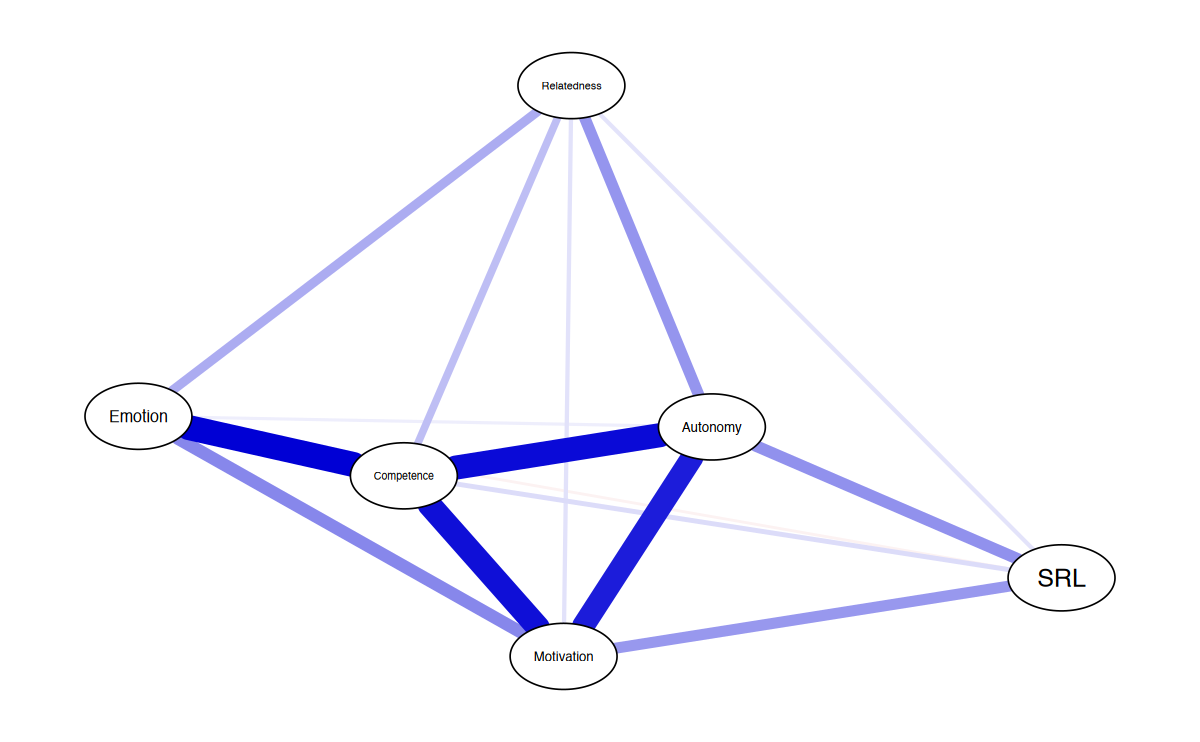

In [9]:
allDataPlot <- plot(allNetwork)
LX <- allDataPlot$layout

Possiamo salvare il grafico in un oggetto R, ad esempio con il nome `allDataPlot`.

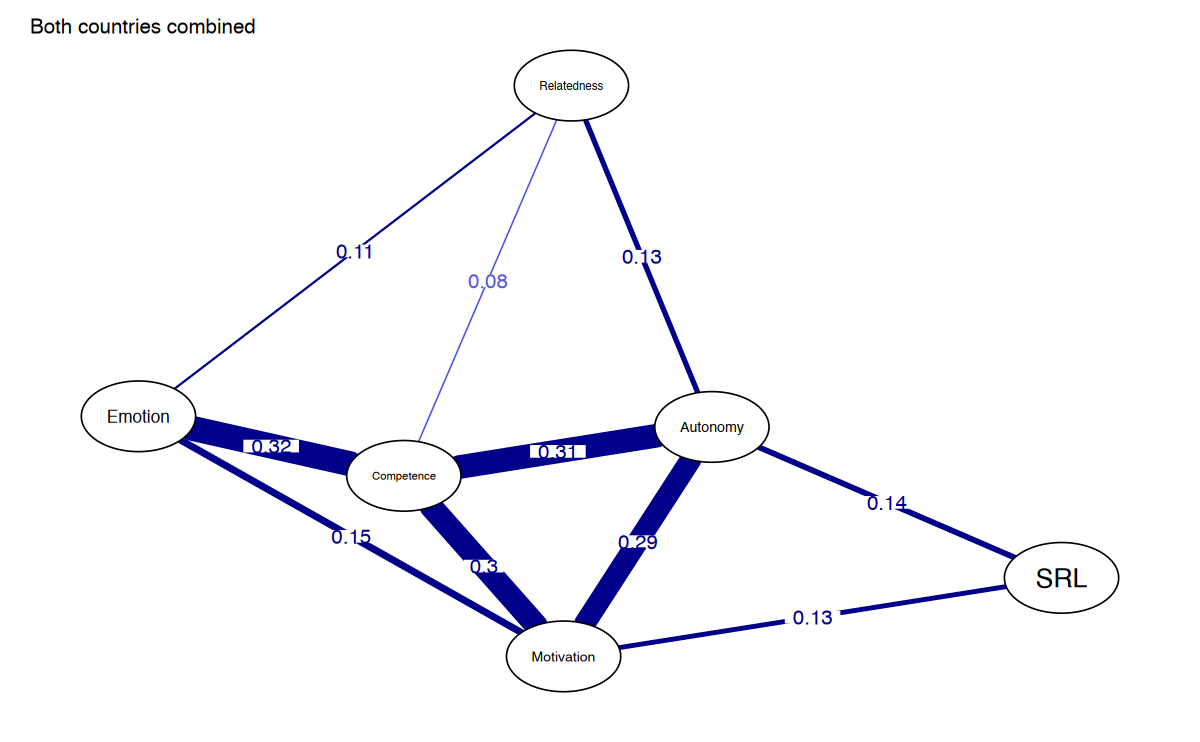

In [10]:
allDataPlot <- plot(
    allNetwork,
    title = "Both countries combined",
    vsize = 9,
    edge.labels = TRUE,
    cut = 0.10,
    minimum = 0.05,
    layout = "spring"
)

 Questo è utile perché l'oggetto contiene non solo il grafico, ma anche altri dati utili come:

- La matrice di correlazione.
- I parametri di configurazione del grafico.
- Gli argomenti della funzione.

Ad esempio, l'oggetto `allDataPlot$layout` contiene il layout della rete (la disposizione dei nodi), che può essere salvato e riutilizzato per garantire la coerenza visiva tra grafici di reti diverse, facilitandone il confronto.

Nella maggior parte dei casi, è utile personalizzare il grafico per migliorare la leggibilità e l'interpretazione. Alcuni esempi di personalizzazione includono:

1. **Titolo del grafico**: Aggiunto con l'argomento `title`. 

2. **Dimensione dei nodi**: Regolata con `vsize`. 

3. **Mostrare i pesi degli archi**: Impostando `edge.labels = TRUE` per visualizzare i valori numerici delle correlazioni.

4. **Soglia di visibilità degli archi**:
   - Utilizzare `cut = 0.10` per evidenziare gli archi con correlazioni superiori a 0.10. Gli archi con correlazioni inferiori saranno visualizzati con una minore intensità del colore.
   - Nascondere (ma non eliminare) archi con valori inferiori a 0.05 con `minimum = 0.05`. Questo aiuta a ridurre il "rumore" visivo nel grafico.

5. **Disposizione dei nodi (layout)**: Utilizzare un layout coerente, ad esempio `"spring"` per posizionare automaticamente i nodi.

## Interpretare le Relazioni nella Rete: Predicibilità dei Nodi

Un'analisi utile consiste nel calcolare la **predicibilità** di ciascun nodo della rete. La predicibilità rappresenta la proporzione di varianza di un nodo che può essere spiegata dalle sue connessioni con gli altri nodi. In pratica, si tratta di calcolare quanto ciascun nodo è influenzato dalle relazioni con gli altri nodi della rete.

La predicibilità di un nodo si basa su una semplice regressione lineare:

1. Per ciascun nodo, si considera come variabile dipendente.
2. Tutti gli altri nodi vengono utilizzati come predittori.
3. Si calcola il coefficiente $R^2$, che indica la percentuale di varianza spiegata.

Questo processo viene ripetuto per ogni nodo nella rete. 

- Quando $R^2 = 0$: Il nodo non è spiegato dalle sue connessioni. In questo caso, è opportuno chiedersi se il nodo è pertinente alla rete o se ci sono problemi nella misurazione di quella variabile.
- Quando $R^2 = 1$: Il nodo è completamente spiegato dalle sue connessioni (100% della varianza). Questo risultato è molto improbabile e potrebbe indicare un errore nel modello o dati altamente ridondanti.

La predicibilità è anche collegata al concetto di **controllabilità**, ossia la misura in cui un nodo può influenzare gli altri nodi della rete. Ad esempio, se un intervento è mirato a un nodo con alta predicibilità, potrebbe essere possibile controllare indirettamente altri nodi connessi. Questo è particolarmente utile per identificare **target di intervento** in contesti applicativi, come la psicologia clinica o l’educazione.

Per calcolare la predicibilità, utilizziamo la funzione `mgm()` del pacchetto **mgm**, che permette di stimare il modello di rete necessario. Viene richiesta la specifica del tipo di ciascuna variabile. Ad esempio, se tutte le variabili sono gaussiane (variabili continue), il parametro sarà:
    ```r
    type = rep('g', 6)
    ```

In [11]:
fitAllData <- mgm(as.matrix(allData), 
    type = c("g", "g", "g", "g", "g", "g")
)

  |------------------------------------------------------------------| 100%
Note that the sign of parameter estimates is stored separately; see ?mgm

Interpretazione dei risultati:

- Un valore di predicibilità basso ($R^2$ vicino a 0) indica che il nodo è debolmente connesso alla rete e potrebbe essere considerato un "outlier" o mal misurato.
- Un valore moderato ($R^2$ tra 0.3 e 0.7) indica che il nodo è spiegato in parte dalle sue connessioni e contribuisce significativamente alla rete.
- Un valore molto alto ($R^2$ vicino a 1) è raro e potrebbe suggerire che il nodo è fortemente ridondante o che il modello è sovrastimato.

La **predicibilità** di ciascuna variabile della rete può essere ottenuta esaminando l’oggetto risultante dal modello di rete. Questo permette di valutare, per ogni nodo, la proporzione di varianza spiegata dalle sue relazioni con gli altri nodi della rete.

In [12]:
# Compute the predictability
predictAll <- predict(fitAllData, na.omit(allData))
predictAll$errors$R2

[1] 0.139 0.518 0.442 0.315 0.458 0.126


Oltre alla predicibilità dei singoli nodi, è possibile calcolare la **predicibilità media** per ottenere una misura complessiva di quanto, in media, i nodi della rete sono spiegati dalle loro connessioni. Questo fornisce un’indicazione generale della qualità esplicativa della rete nel suo insieme.

In [13]:
mean(predictAll$errors$R2) # Mean predictability

[1] 0.333

Un’altra misura utile è l’**Errore Quadratico Medio (RMSE)**, che indica la differenza tra i valori previsti e quelli osservati per ciascun nodo. Questo valore può essere ottenuto esaminando l’oggetto risultante come segue:

In [14]:
mean(predictAll$errors$RMSE) # Mean RMSE

[1] 0.811

**Interpretazione**

1. **Predicibilità ($R^2$):**
   - Valori elevati ($R^2$ vicino a 1): Il nodo è altamente spiegato dalle sue relazioni con gli altri nodi della rete.
   - Valori bassi ($R^2$ vicino a 0): Il nodo è poco spiegato dalle sue connessioni e potrebbe richiedere ulteriori verifiche, ad esempio sulla sua pertinenza al modello o sulla qualità della sua misurazione.

2. **Errore Quadratico Medio (RMSE):**
   - Un RMSE basso indica che il modello di rete prevede accuratamente i valori osservati per ciascun nodo.
   - Un RMSE alto suggerisce che le connessioni nel modello spiegano meno bene i valori effettivi del nodo, indicando potenziali problemi nel modello o nei dati.

Possiamo salvare i risultati in un dataframe:

In [15]:
data.frame(
    var = predictAll$errors$Variable,
    R2 = predictAll$errors$R2,
    RMSE = predictAll$errors$RMSE
)

var,R2,RMSE
<chr>,<dbl>,<dbl>
Relatedness,0.139,0.928
Competence,0.518,0.694
Autonomy,0.442,0.747
Emotion,0.315,0.828
Motivation,0.458,0.736
SRL,0.126,0.935


Come mostrano il grafico della rete con la predicibilità rappresentata come grafici a torta nei nodi e il relativo data frame, i nodi con la **predicibilità più alta** sono quelli relativi a competenza, motivazione e autonomia. Al contrario, i nodi relativi all’apprendimento autoregolato (**SRL**) e alla relazionalità presentano una **predicibilità più bassa**, risultando quindi meno spiegati dalle loro connessioni con gli altri nodi della rete.

- **Alta predicibilità** (competenza, motivazione, autonomia): questi nodi sono fortemente influenzati dalle relazioni con gli altri nodi, suggerendo che i loro valori dipendono in larga misura dalle connessioni nella rete. Ciò può indicare che questi costrutti sono centrali e ben integrati nel modello.
- **Bassa predicibilità** (SRL, relazionalità): questi nodi sono debolmente spiegati dalle connessioni, il che può suggerire che:

  - Le variabili potrebbero essere meno centrali nella rete.
  - Potrebbero mancare connessioni significative con altri nodi.
  - Potrebbero esserci problemi nella misurazione o nella definizione di questi costrutti.

Implicazioni:

- I nodi con alta predicibilità possono essere considerati **target strategici per interventi**, poiché le loro connessioni hanno un impatto significativo sugli altri nodi.
- Per i nodi con bassa predicibilità, potrebbe essere utile approfondire ulteriormente il loro ruolo nel modello, considerando possibili revisioni del questionario o integrazioni con ulteriori variabili esplicative.

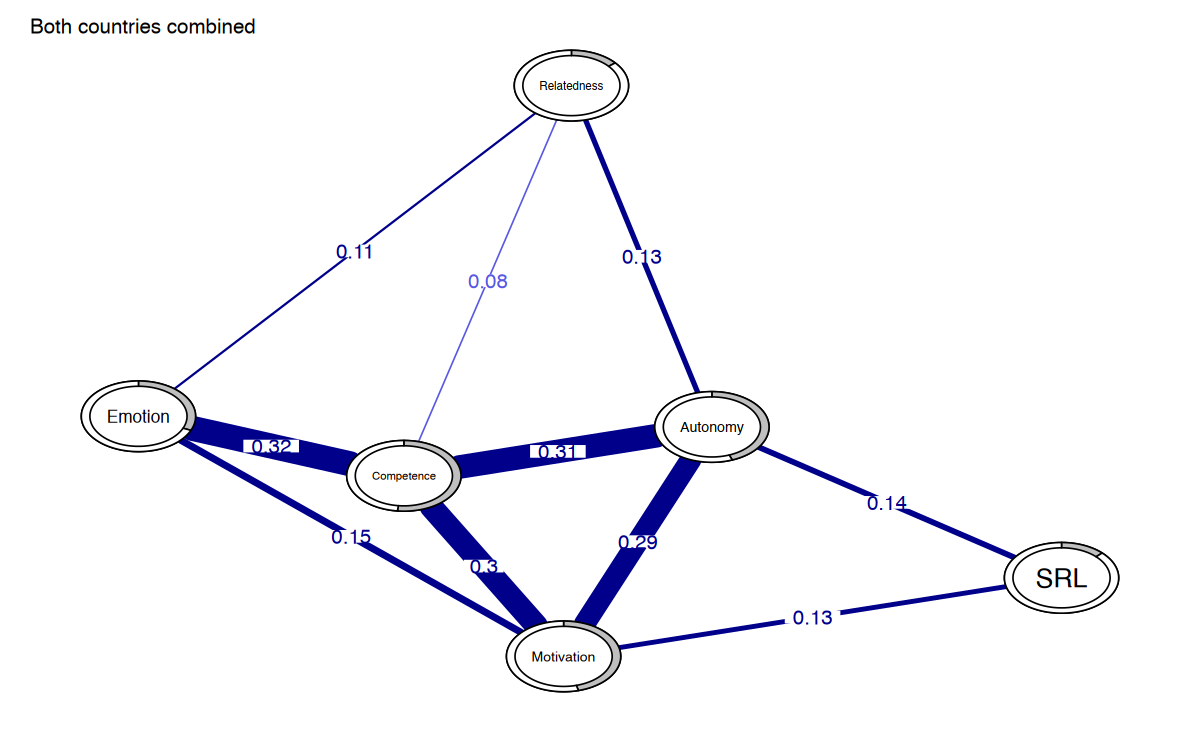

In [16]:
allDataPlot <- plot(
    allNetwork,
    title = "Both countries combined",
    vsize = 9,
    edge.labels = TRUE,
    cut = 0.10,
    minimum = 0.05,
    pie = predictAll$errors$R2
)

## Inferenza sulla Rete: Misure di Centralità

Come nelle reti tradizionali, anche nelle reti psicologiche è possibile calcolare le **misure di centralità**. Queste misure permettono di individuare i nodi più influenti, importanti o centrali all'interno della rete. Tuttavia, l’interpretazione di queste misure dipende da diversi fattori:

- Le variabili incluse nella rete.
- Il metodo di stima utilizzato.
- I pesi degli archi (connessioni tra i nodi).
- Le basi teoriche che guidano la struttura della rete.

Le misure di centralità possono essere utili per identificare potenziali **bersagli di intervento**, ossia nodi il cui cambiamento potrebbe avere un impatto significativo sull’intera rete.

Tra le molteplici misure di centralità disponibili, due sono particolarmente diffuse e raccomandate:

1. **Grado di centralità (degree centrality):** Conta il numero di connessioni di un nodo, indipendentemente dal peso degli archi.
2. **Forza di centralità (strength centrality):** Somma i pesi assoluti di tutte le connessioni di un nodo (sia positivi che negativi).
3. **Influenza attesa (expected influence):** Simile alla centralità di forza, ma somma i pesi grezzi delle connessioni, senza considerare i valori assoluti.

Altre misure, come **betweenness**, **closeness** e **eigenvector centrality**, possono essere calcolate, ma la loro interpretazione è meno chiara e non sono generalmente raccomandate per un’analisi standard.

Per fare un esempio, consideriamo un nodo con le seguenti connessioni: 0.3, -0.1 e 0.5. Le misure di centralità sono:

- **Degree centrality:** 3 (numero delle connessioni).
- **Strength centrality:** $|0.3| + |-0.1| + |0.5| = 0.9$ (somma dei pesi assoluti).
- **Expected influence:** $0.3 + (-0.1) + 0.5 = 0.7$ (somma dei pesi grezzi).

Nota: Quando la rete non contiene archi negativi, la centralità di forza e l'influenza attesa coincidono.

Per visualizzare le misure di centralità, utilizziamo la funzione `centralityPlot()` del pacchetto **bootnet**. L’argomento `include` specifica le centralità da calcolare, e l’opzione `scale = "z-scores"` visualizza i valori di centralità standardizzati (z-score) sull’asse x, invece dei valori grezzi.

Note: z-scores are shown on x-axis rather than raw centrality indices.



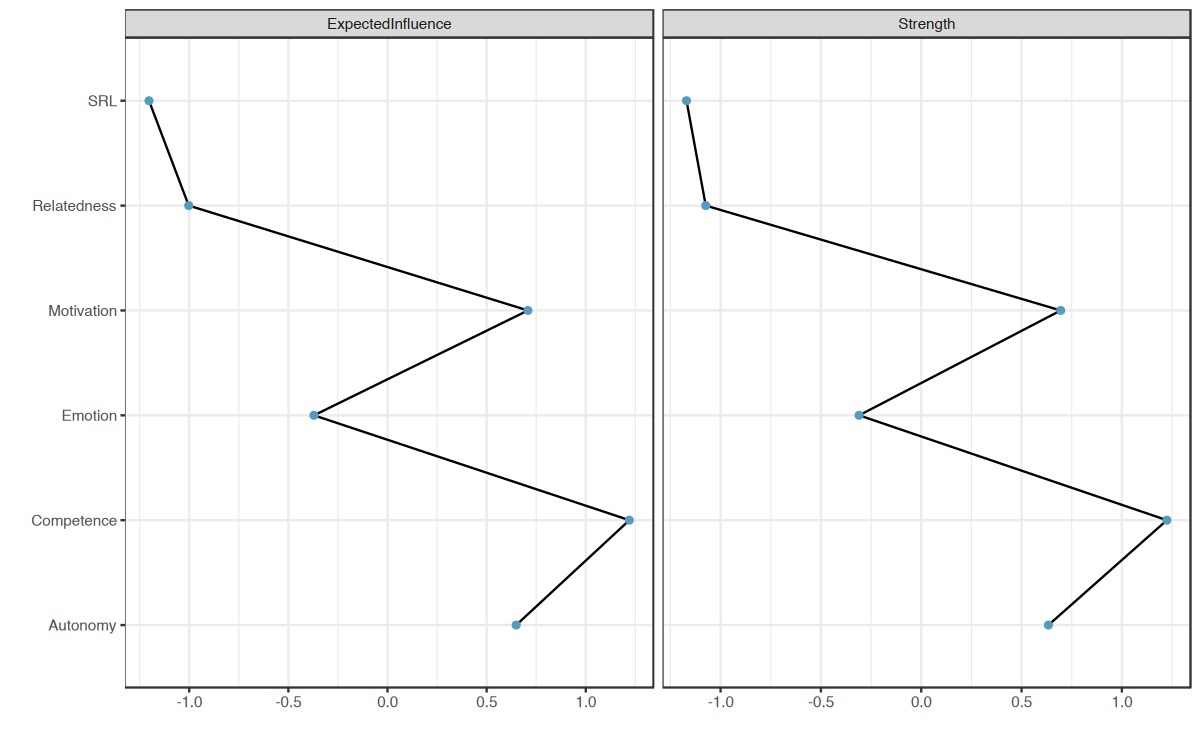

In [17]:
centralityPlot(allNetwork,
    include = c("ExpectedInfluence", "Strength"),
    scale = "z-scores"
)

Se si desiderano solo i valori numerici delle centralità, possiamo utilizzare la funzione `centralityTable()`:

In [18]:
centralityTable(allNetwork)

graph,type,node,measure,value
<chr>,<lgl>,<chr>,<fct>,<dbl>
graph 1,NA,Relatedness,Betweenness,-0.617
graph 1,NA,Competence,Betweenness,0.772
graph 1,NA,Autonomy,Betweenness,1.697
graph 1,NA,Emotion,Betweenness,-0.617
graph 1,NA,Motivation,Betweenness,-0.617
graph 1,NA,SRL,Betweenness,-0.617
graph 1,NA,Relatedness,Closeness,-1.144
graph 1,NA,Competence,Closeness,0.721
graph 1,NA,Autonomy,Closeness,1.206


Un’alternativa per calcolare diverse tipologie di centralità è l’utilizzo del pacchetto **NetworkToolbox**. Questo pacchetto offre un’ampia gamma di misure di centralità, tra cui:

- **Degree centrality**: Numero di connessioni di un nodo.
- **Strength centrality**: Somma dei pesi assoluti delle connessioni di un nodo.
- **Closeness centrality**: Misura della "vicinanza" di un nodo a tutti gli altri nella rete.
- **Eigenvector centrality**: Valuta l'importanza di un nodo tenendo conto anche dell'importanza dei suoi vicini.
- **Leverage centrality**: Misura il peso relativo delle connessioni di un nodo rispetto ai suoi vicini.

Oltre a queste, il pacchetto include molte altre misure di centralità che possono essere esplorate per analisi specifiche. Per ulteriori dettagli sull’utilizzo delle funzioni e sulle opzioni disponibili, è consigliato consultare il manuale del pacchetto **NetworkToolbox**.

Sebbene **NetworkToolbox** fornisca una vasta gamma di misure di centralità, è importante ricordare che:

- Alcune di queste misure, come **closeness**, **betweenness** ed **eigenvector centrality**, non sono ancora ben comprese o facili da interpretare nel contesto delle reti psicologiche.
- Misure come la **strength centrality** e l’**expected influence** sono generalmente preferite perché hanno un’interpretazione più chiara e diretta.

In [19]:
Degree <- degree(allNetwork$graph)
Strength <- strength(allNetwork$graph)
Betweenness <- betweenness(allNetwork$graph)
Closeness <- closeness(allNetwork$graph)
Eigenvector <- eigenvector(allNetwork$graph)
Leverage <- leverage(allNetwork$graph)
data.frame(
    Var = names
    (Degree), Degree, Strength, Betweenness, Closeness,
    Eigenvector, Leverage
)

,Var,Degree,Strength,Betweenness,Closeness,Eigenvector,Leverage
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Relatedness,Relatedness,5,0.40,0,1.89,0.217,-3.429
Competence,Competence,5,1.07,6,3.27,0.553,1.349
Autonomy,Autonomy,5,0.90,10,3.63,0.475,1.066
Emotion,Emotion,5,0.62,0,2.58,0.363,-0.425
Motivation,Motivation,5,0.91,0,3.16,0.495,1.105
SRL,SRL,5,0.37,0,1.88,0.211,-5.379


## Altre Opzioni per la Stima delle Reti

Come accennato in precedenza, oltre alle reti basate su correlazioni parziali regolarizzate, esistono diverse altre opzioni di stima delle reti. Di seguito ne presentiamo alcune, ma per ulteriori dettagli si consiglia di consultare le pagine del manuale della funzione `estimateNetwork()`.

### Rete di Associazione 

La **rete di associazione** (*correlation network*) si basa sulle correlazioni semplici tra le variabili. Questo tipo di rete è utile principalmente per **esplorazioni preliminari dei dati**, ma non è generalmente raccomandata per analisi definitive, poiché tende a produrre reti molto dense con molteplici connessioni non significative.

In [20]:
allNetwork_cor <- estimateNetwork(allData,
    default = "cor", verbose = FALSE
)

### Metodo `ggmModSelect()`

Il metodo `ggmModSelect()` è particolarmente indicato per dataset **di grandi dimensioni** con un **numero ridotto di nodi**. Funziona in questo modo:

1. Parte da una rete regolarizzata come punto di riferimento iniziale.
2. Stima tutte le possibili reti **non regolarizzate**.
3. Seleziona il modello migliore in base al criterio EBIC (Extended Bayesian Information Criterion), scegliendo quello con il valore più basso.

Questo approccio combina i vantaggi della regolarizzazione con la flessibilità di reti non regolarizzate, risultando in un modello più accurato per dataset specifici.

In [21]:
allNetwork_mgm <- estimateNetwork(allData,
    default = "ggmModSelect", verbose = FALSE
)

### Rete di Importanza Relativa

La rete di **importanza relativa** (`relimp`; *Relative Importance Network*) stima una rete **direzionale** basata sull'importanza relativa dei predittori in un modello di regressione lineare. In questa rete:

- Gli archi rappresentano la magnitudine dell'importanza relativa di ciascun predittore.
- La direzione degli archi indica come ciascuna variabile influenza le altre, secondo i risultati della regressione.

Questa rete è utile per identificare relazioni causali teoriche o per evidenziare come alcune variabili predicono altre all'interno del dataset.

In [22]:
allNetwork_relimp <- estimateNetwork(allData,
    default = "relimp", verbose = FALSE
)

Caricamento dei namespace richiesti: relaimpo



### Confronto tra i Modelli

- La **rete `ggmModSelect()`** produce risultati molto simili alla rete regolarizzata standard, con differenze minime nelle connessioni più deboli.
- La **rete di associazione** è invece **molto densa**, poiché include tutte le correlazioni, senza applicare alcuna penalizzazione.
- La **rete di importanza relativa** è direzionale e fornisce informazioni aggiuntive su come una variabile influenza le altre.

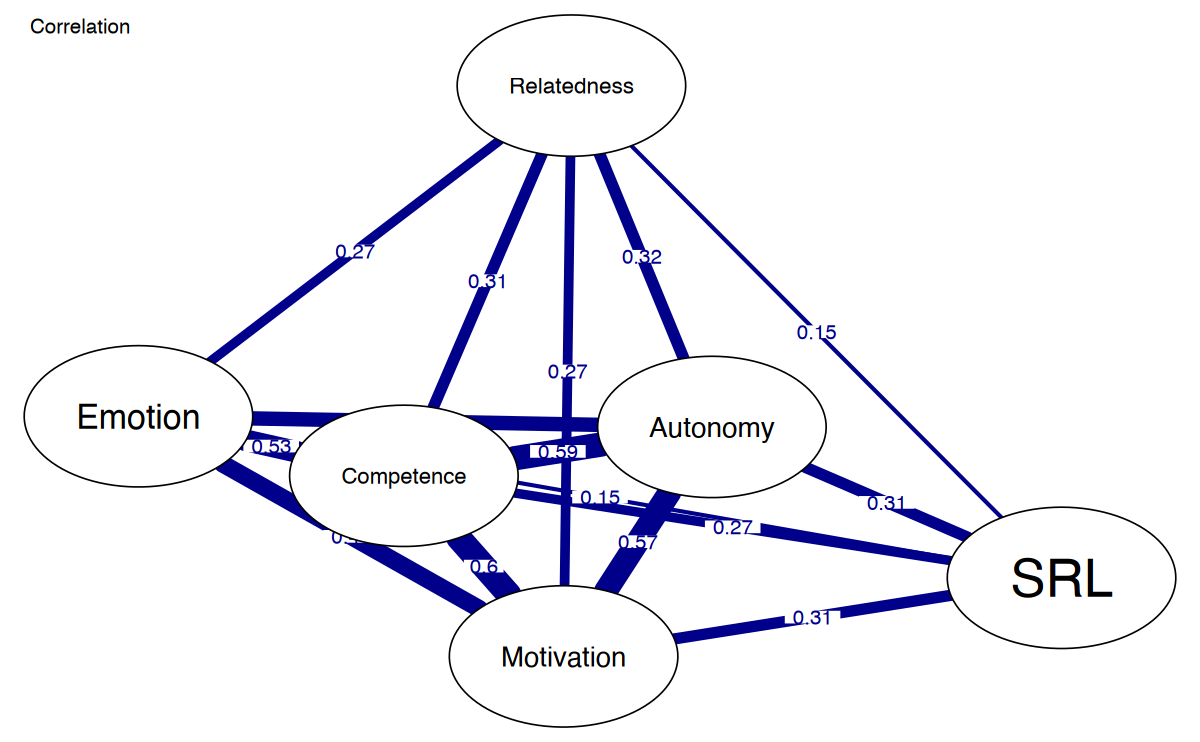

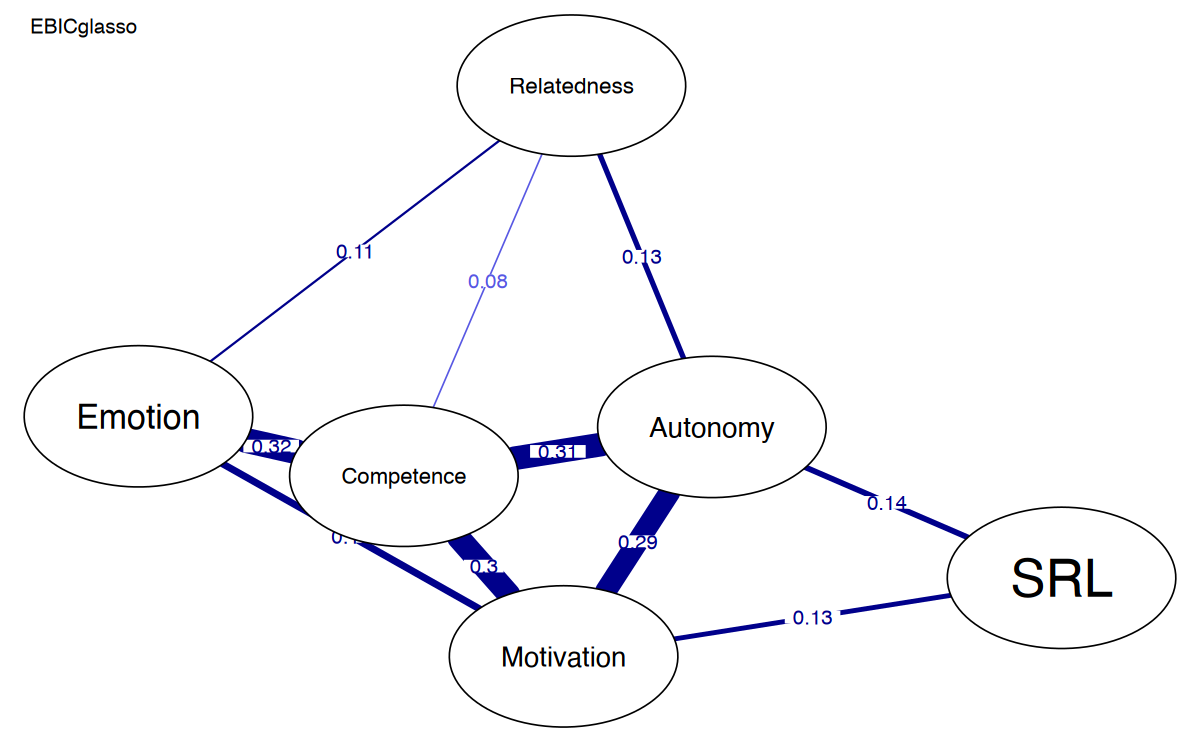

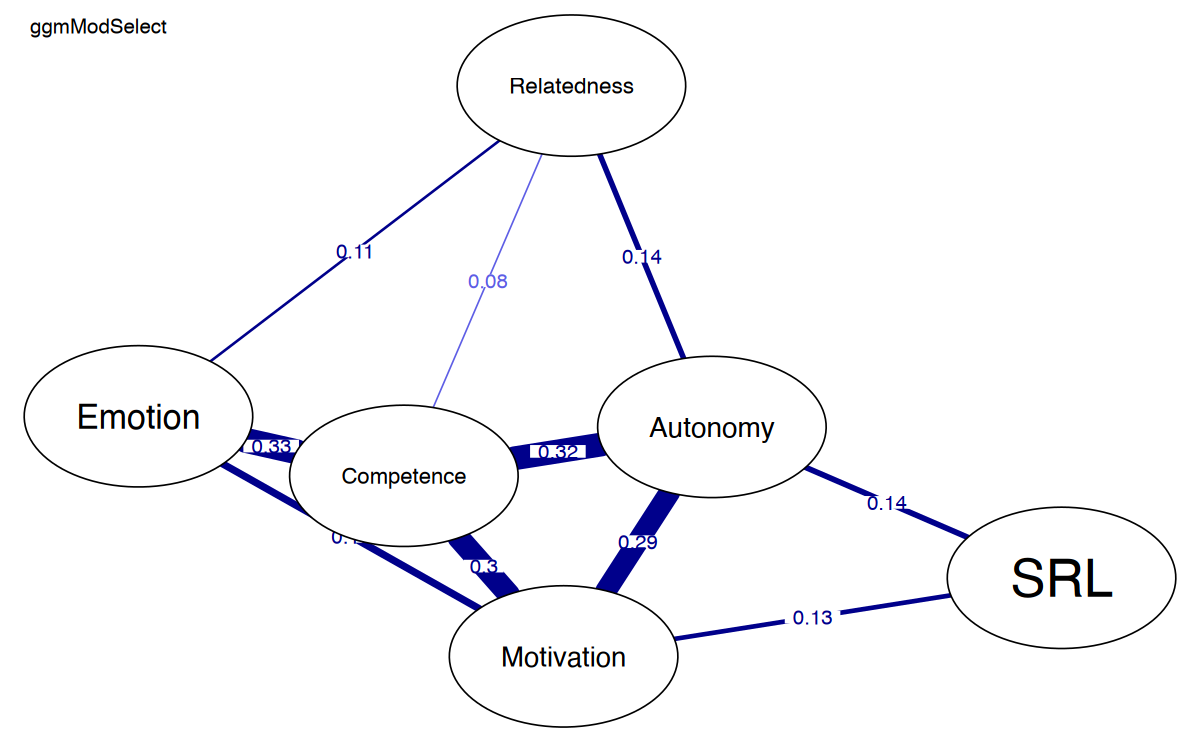

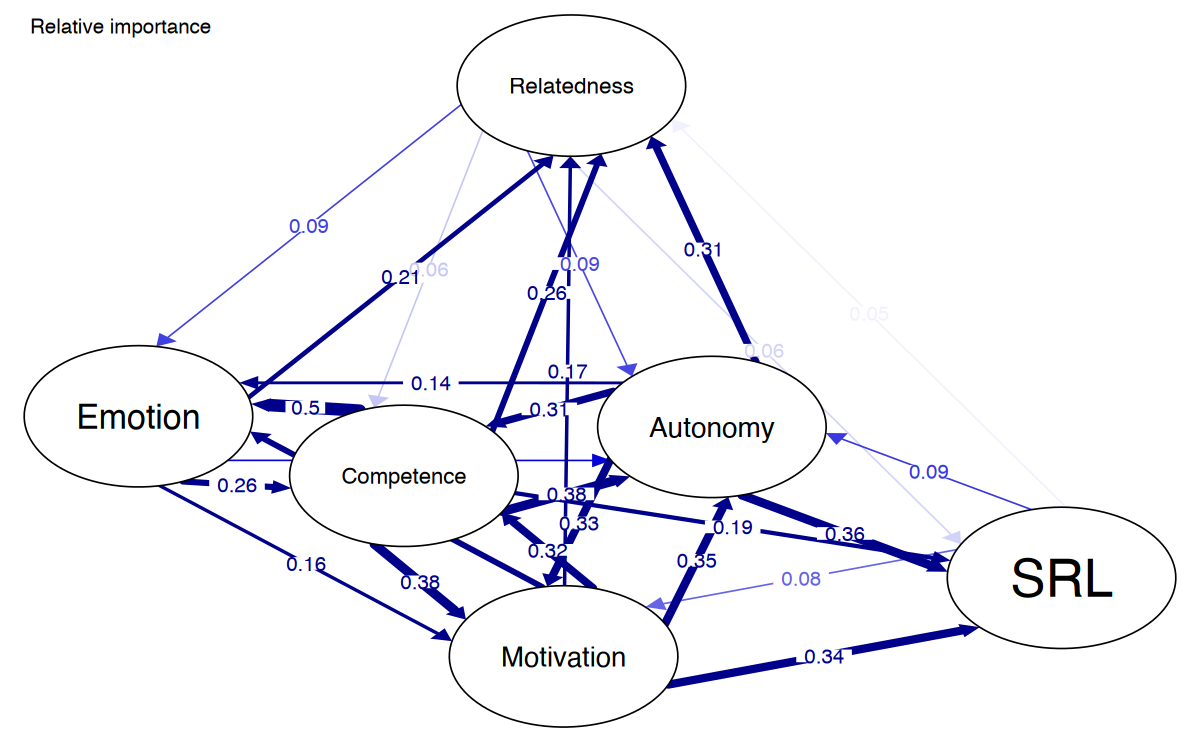

In [23]:
plot(
    allNetwork_cor, title = "Correlation", vsize = 18, edge.labels = TRUE, 
    cut = 0.10, minimum = 0.05, layout = LX
)
plot(
    allNetwork, title = "EBICglasso", vsize = 18, edge.labels = TRUE,
    cut = 0.10, minimum = 0.05, layout = LX
)
plot(
    allNetwork_mgm, title = "ggmModSelect", vsize = 18, edge.labels = TRUE,
    cut = 0.10, minimum = 0.05, layout = LX
)
plot(
    allNetwork_relimp, title = "Relative importance", vsize = 18, 
    edge.labels = TRUE, cut = 0.10, minimum = 0.05, layout = LX
)

## Confronto tra Reti

Dopo aver illustrato i passaggi fondamentali per stimare una singola rete, procediamo ora al confronto tra diverse reti. Le reti psicologiche offrono metodi per confrontare le reti nel loro complesso, i pesi degli archi (edge weights) e le misure di centralità.

Nel nostro caso, disponendo di dati provenienti da due paesi (Finlandia e Austria), possiamo stimare due reti separate, una per ciascun paese, e confrontarle per osservare come differiscono.

Per confrontare le reti, dobbiamo innanzitutto stimarle separatamente per ciascun paese. I passaggi di stima sono gli stessi descritti in precedenza. Per ciascun paese, iniziamo con i passi seguenti:

- Controllo delle assunzioni per ciascun dataset (ad esempio, verifica che la matrice di correlazione sia positiva definita).
- Verifica con l'algoritmo **goldbricker** per identificare nodi altamente simili che potrebbero necessitare di essere combinati o ridotti. In questo caso, i risultati mostrano che:
  - Le matrici di correlazione di entrambe le reti sono già positive definite.
  - Non ci sono nodi altamente simili che richiedono riduzioni.

In [24]:
### Check the assumptions
## Finland
# check for positive definitiveness
correlationMatrix <- cor(
    x = finlandData, 
    use = c("pairwise.complete.obs")
)

is.positive.definite(correlationMatrix)
# check for redundancy
goldbricker(finlandData,
    p = 0.05, method = "hittner2003",
    threshold = 0.25, corMin = 0.5, progressbar = FALSE
)

[1] TRUE

Suggested reductions: Less than 25 % of correlations are significantly different for the following pairs: 
[1] "No suggested reductions"

In [25]:
## Austria
# check for positive definitiveness
correlationMatrix <- cor(
    x = austriaData, 
    use = c("pairwise.complete.obs")
)

is.positive.definite(correlationMatrix)
# check for redundancy
goldbricker(austriaData,
    p = 0.05, method = "hittner2003",
    threshold = 0.25, corMin = 0.5, progressbar = FALSE
)

[1] TRUE

Suggested reductions: Less than 25 % of correlations are significantly different for the following pairs: 
[1] "No suggested reductions"

Stima dei networks:

In [26]:
#| output: false
#| warning: false

# Estimate the networks
finlandNetwork <- estimateNetwork(
    finlandData,
    default = "EBICglasso", corMethod = "cor_auto", tuning = 0.5
)

austriaNetwork <- estimateNetwork(
    austriaData,
    default = "EBICglasso", corMethod = "cor_auto", tuning = 0.5
)

Estimating Network. Using package::function:
  - qgraph::EBICglasso for EBIC model selection
    - using glasso::glasso
  - qgraph::cor_auto for correlation computation
    - using lavaan::lavCor

Warning message in EBICglassoCore(S = S, n = n, gamma = gamma, penalize.diagonal = penalize.diagonal, :
"A dense regularized network was selected (lambda < 0.1 * lambda.max). Recent work indicates a possible drop in specificity. Interpret the presence of the smallest edges with care. Setting threshold = TRUE will enforce higher specificity, at the cost of sensitivity."
Estimating Network. Using package::function:
  - qgraph::EBICglasso for EBIC model selection
    - using glasso::glasso
  - qgraph::cor_auto for correlation computation
    - using lavaan::lavCor

Note: Network with lowest lambda selected as best network: assumption of sparsity might be violated.

Warning message in EBICglassoCore(S = S, n = n, gamma = gamma, penalize.diagonal = penalize.diagonal, :
"A dense regularized network

Calcoliamo la predicibilità per ciascun paese.

In [27]:
# Compute the predictability
fitFinland <- mgm(
    as.matrix(finlandData), # data
    c("g", "g", "g", "g", "g", "g"),
    # distribution for each var
    verbatim = TRUE, # hide warnings and progress bar
    signInfo = FALSE # hide message about signs
)

In [28]:
predictFinland <- predict(fitFinland, na.omit(finlandData))
mean(predictFinland$errors$R2)
mean(predictFinland$errors$RMSE)

[1] 0.308

[1] 0.828

In [29]:
fitAustria <- mgm(
    as.matrix(austriaData), # data
    c("g", "g", "g", "g", "g", "g"),
    # distribution for each var
    verbatim = TRUE, # hide warnings and progress bar
    signInfo = FALSE # hide message about signs
)

In [30]:
predictAustria <- predict(fitAustria, na.omit(austriaData))
mean(predictAustria$errors$R2)
mean(predictAustria$errors$RMSE)

[1] 0.344

[1] 0.804

Dopo aver stimato le reti, possiamo visualizzarle per facilitare il confronto. Questo approccio consente di identificare rapidamente le differenze e le somiglianze tra le reti dei due paesi.

In [31]:
AverageLayout <- averageLayout(finlandNetwork, austriaNetwork)

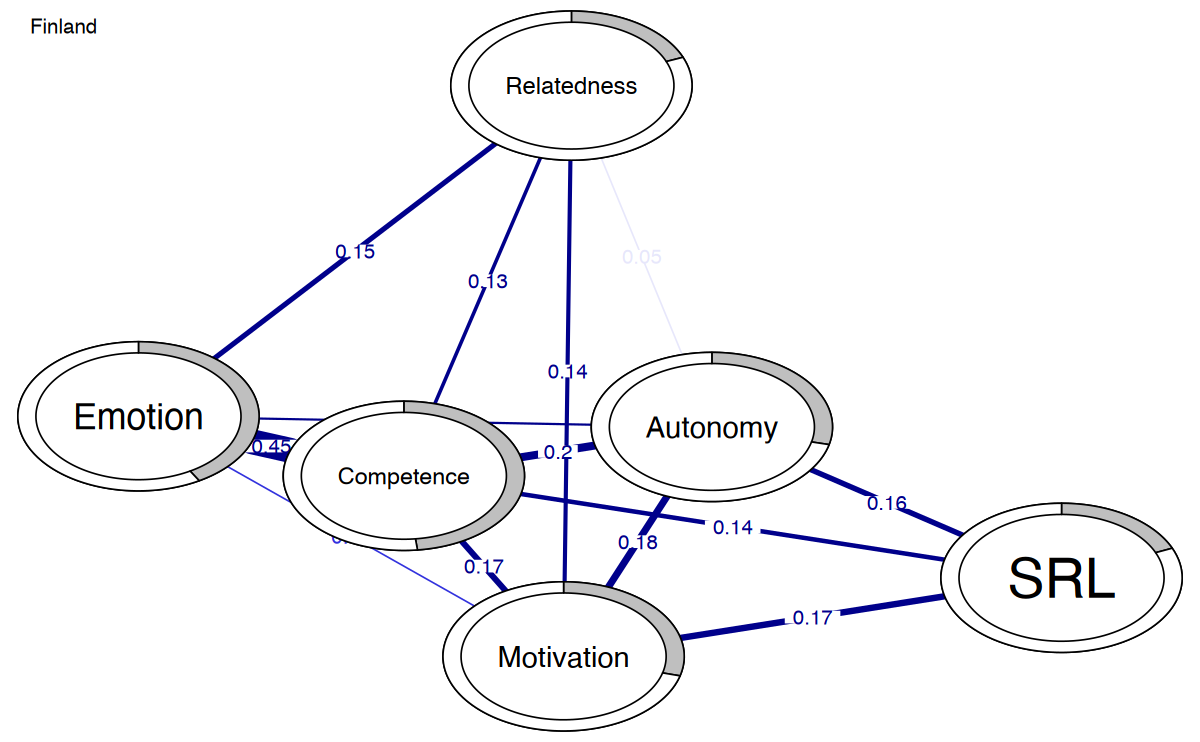

In [32]:
plot(finlandNetwork, # input network
    title = "Finland", # plot title
    vsize = 19, # size of the nodes
    edge.labels = TRUE, # label the edge weights
    cut = 0.10, # saturate edges > .10
    minimum = 0.05, # remove edges < .05
    pie = predictFinland$errors$R2, # put R2 as pie
    layout = LX
) # set the layout

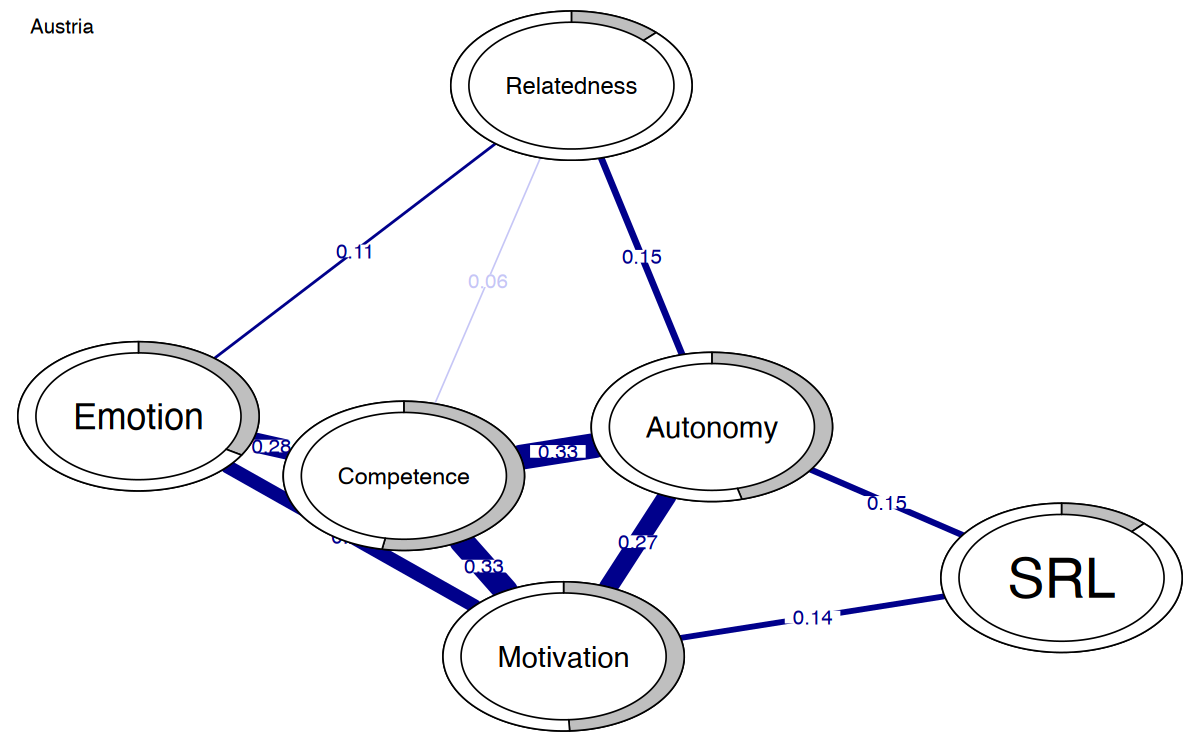

In [33]:
plot(austriaNetwork, # input network
    title = "Austria", # plot title
    vsize = 19, # size of the nodes
    edge.labels = TRUE, # label the edge weights
    cut = 0.10, # saturate edges > .10
    minimum = 0.05, # remove edges < .05
    pie = predictAustria$errors$R2, # put R2 as pie
    layout = LX
) # set the layout

Possiamo rappresentare graficamente la differenza tra le due reti usando `qgraph()`. La funzione `qgraph()` richiede come input una rete stimata o una matrice. Per creare una rete di differenza, è necessario sottrarre le due matrici delle connessioni delle reti (ad esempio, `finlandNetwork$graph - austriaNetwork$graph`). 

Il seguente codice mostra come visualizzare la **rete di differenza** che evidenzia le variazioni nei pesi delle connessioni tra le due reti.

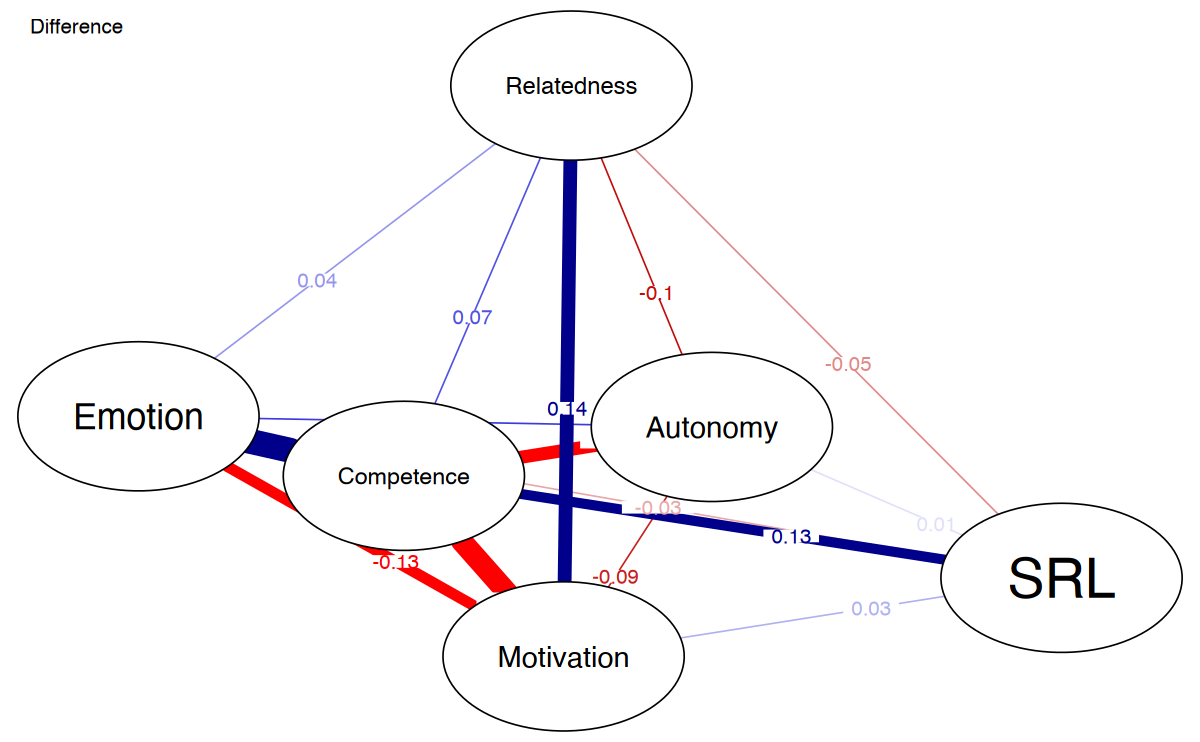

In [34]:
qgraph(finlandNetwork$graph - abs(austriaNetwork$graph),
    title = "Difference", # plot title
    theme = allDataPlot$Arguments$theme,
    vsize = 19, # size of the nodes
    edge.labels = TRUE, # label the edge weights
    labels = allDataPlot$Arguments$labels, # node labels
    cut = 0.10, # saturate edges > .10
    layout = LX
) # set the layout

Il confronto tra le reti evidenzia differenze tra i due paesi:

- **Finlandia**:
  - Connessione più forte tra **competenza** ed **emozione**.
  - Connessione più forte tra **motivazione** e **relazionalità**.

- **Austria**:
  - Connessioni più forti tra:
    - **Motivazione** e **competenza**.
    - **Motivazione** ed **emozione**.
    - **Competenza** e **autonomia**.
    - **Autonomia** e **relazionalità**.

Queste differenze suggeriscono che le relazioni psicologiche tra le variabili possono essere influenzate da fattori specifici di ciascun contesto culturale o sociale. La rete di differenza rappresenta un utile strumento visivo per evidenziare queste variazioni e guidare l’interpretazione.

Un confronto visivo delle centralità può essere effettuato nello stesso modo descritto in precedenza. Per farlo, forniamo le reti che vogliamo confrontare come una lista e specifichiamo le misure di centralità da calcolare.

I risultati mostrano che:

- Nella rete dell'**Austria**, la variabile con il valore di centralità più alto è la **motivazione**, indicando che la motivazione è il fattore principale che guida la connettività nella rete.
- Nella rete della **Finlandia**, la variabile più centrale è la **competenza**, che risulta essere il driver principale della connettività della rete.

Questo confronto mette in evidenza come le variabili centrali differiscano tra i due contesti, suggerendo che fattori culturali o ambientali possono influenzare il ruolo delle variabili psicologiche nella struttura della rete.

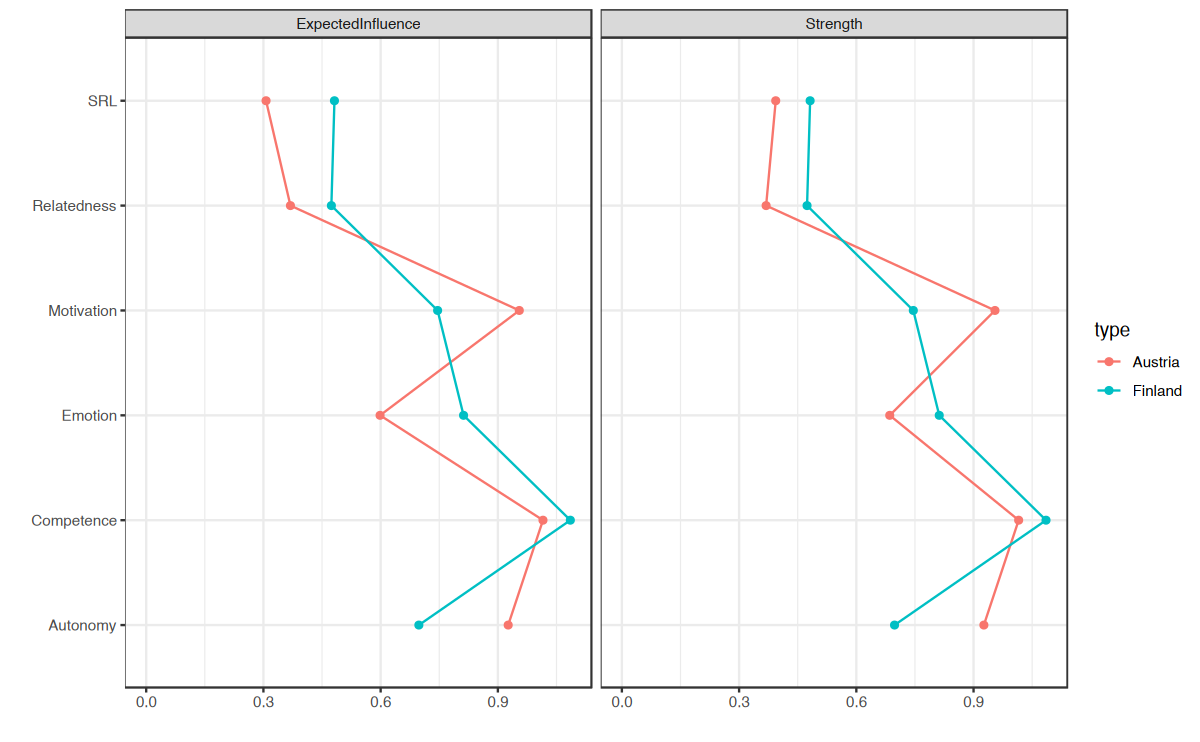

In [35]:
centralityPlot(
    list(
        Finland = finlandNetwork,
        Austria = austriaNetwork
    ),
    include = c("ExpectedInfluence", "Strength")
)

## Confronto Statistico tra Reti 

Per confrontare in modo rigoroso le reti, è necessario utilizzare un test statistico che permetta di stabilire quali differenze nei pesi degli archi o nelle misure di centralità siano significative e non dovute al caso. Il **Network Comparison Test (NCT)** è uno strumento per effettuare un confronto dettagliato della struttura delle reti, dei pesi degli archi e delle centralità.

L’NCT utilizza un approccio basato su permutazioni:

1. Genera un grande numero di reti permutate a partire dalle reti originali, creando una distribuzione di riferimento.
2. Confronta le reti originali con quelle permutate per determinare se le differenze osservate sono statisticamente significative.

Per eseguire il test, dobbiamo:

- Fornire le due reti da confrontare.
- Specificare il numero di iterazioni (almeno 1000 è raccomandato per risultati affidabili).
- Testare gli **archi** con `test.edges = TRUE` e `edges = 'all'` per verificare tutte le connessioni.
- Testare le **centralità** con `test.centrality = TRUE` (poiché non vengono testate di default).

In [36]:
#| output: false
#| warning: false

set.seed(1337)

Compared <- NCT(
    finlandNetwork, # network 1
    austriaNetwork, # network 2
    verbose = FALSE, # hide warnings and progress bar
    it = 1000, # number of iterations
    abs = TRUE,
    binary.data = FALSE, # set data distribution
    test.edges = TRUE, # test edge differences
    edges = 'all', # which edges to test
    test.centrality = TRUE, # test centrality
    progressbar = FALSE # progress bar
)

Warning message in EBICglassoCore(S = S, n = n, gamma = gamma, penalize.diagonal = penalize.diagonal, :
"A dense regularized network was selected (lambda < 0.1 * lambda.max). Recent work indicates a possible drop in specificity. Interpret the presence of the smallest edges with care. Setting threshold = TRUE will enforce higher specificity, at the cost of sensitivity."
Note: Network with lowest lambda selected as best network: assumption of sparsity might be violated.

Warning message in EBICglassoCore(S = S, n = n, gamma = gamma, penalize.diagonal = penalize.diagonal, :
"A dense regularized network was selected (lambda < 0.1 * lambda.max). Recent work indicates a possible drop in specificity. Interpret the presence of the smallest edges with care. Setting threshold = TRUE will enforce higher specificity, at the cost of sensitivity."
Warning message in EBICglassoCore(S = S, n = n, gamma = gamma, penalize.diagonal = penalize.diagonal, :
"A dense regularized network was selected (lambda 

In [37]:
Compared$glstrinv.sep # Separate global strength values of the individual networks

[1] 2.15 2.17

In [38]:
Compared$einv.pvals # Holm-Bonferroni adjusted p-values for each edge

,Var1,Var2,p-value,Test statistic E
,<fct>,<fct>,<dbl>,<dbl>
7,Relatedness,Competence,0.017982,0.0681
13,Relatedness,Autonomy,0.001998,0.0952
14,Competence,Autonomy,0.000999,0.1348
19,Relatedness,Emotion,0.165834,0.0414
20,Competence,Emotion,0.000999,0.1713
21,Autonomy,Emotion,0.009990,0.0767
25,Relatedness,Motivation,0.000999,0.1371
26,Competence,Motivation,0.000999,0.1605
27,Autonomy,Motivation,0.003996,0.0876


In [39]:
Compared$diffcen.real # Difference in centralities

,strength,expectedInfluence
Relatedness,0.105,0.105
Competence,0.070,0.070
Autonomy,-0.229,-0.229
Emotion,0.127,0.214
Motivation,-0.209,-0.209
SRL,0.088,0.175


In [40]:
Compared$diffcen.pval # Holm-Bonferroni adjusted p-values for each centrality

,strength,expectedInfluence
Relatedness,0.006993,0.006993
Competence,0.127872,0.127872
Autonomy,0.000999,0.000999
Emotion,0.009990,0.000999
Motivation,0.000999,0.000999
SRL,0.132867,0.000999


### Interpretazione dei Risultati

**Forza Globale delle Reti.** Finlandia: 2.15, Austria: 2.17. La differenza tra le due reti ($\Delta = 0.024$) non è statisticamente significativa, indicando che le reti hanno una connettività complessiva simile.

**Differenze nei Pesi degli Archi.** Gli archi **Competence-Autonomy**, **Competence-Emotion**, **Competence-Motivation**, **Relatedness-Competence** e **Relatedness-Motivation** mostrano differenze statisticamente significative ($p < 0.05$). Archi come **Relatedness-Emotion** e **Autonomy-SRL** non mostrano differenze significative.

**Differenze nelle Centralità.** **Autonomy** e **Motivation** hanno differenze significative sia in **strength** che in **expected influence** ($p < 0.001$), suggerendo che il loro ruolo nella rete varia notevolmente tra i due paesi. **Relatedness** e **Emotion** mostrano differenze significative ($p < 0.01$). **Competence** e **SRL** non presentano differenze significative nelle centralità.

In conclusione, le reti di Finlandia e Austria hanno una forza globale simile, ma mostrano differenze significative in alcune connessioni chiave e centralità. **Competence**, **Autonomy**, e **Motivation** giocano ruoli diversi nei due contesti culturali.
 Le differenze nei pesi degli archi e nelle centralità suggeriscono influenze specifiche di fattori contestuali o culturali.

## La Rete della Variabilità

La **rete della variabilità** fornisce un'indicazione di come i pesi degli archi (le connessioni tra nodi) variano tra le reti. In altre parole, questa rete riflette il **grado di variabilità** o le **differenze individuali** presenti nella popolazione analizzata.

- **Archi con bassa variabilità:** Indicano che le connessioni sono simili tra le reti, ovvero stabili e consistenti.
- **Archi con alta variabilità:** Indicano che le connessioni differiscono significativamente tra le reti, suggerendo la presenza di differenze individuali o contestuali.

Per costruire la rete della variabilità, calcoliamo la deviazione standard dei pesi degli archi tra le due reti. Il processo include:

1. La creazione di due matrici, una per ciascuna rete.
2. Un ciclo che calcola la deviazione standard per ogni arco tra le due reti.

In [41]:
# Construct a network where edges are standard deviations across edge weights of networks
edgeMeanJoint <- matrix(0, 6, 6)
edgeSDJoint <- matrix(0, 6, 6)
for (i in 1:6) {
    for (j in 1:6) {
        vector <- c(getWmat(finlandNetwork)[i, j], getWmat
        (austriaNetwork)[i, j])
        edgeMeanJoint[i, j] <- mean(vector)
        edgeSDJoint[i, j] <- sd(vector)
    }
}

Successivamente, tracciamo le reti in cui i pesi degli archi rappresentano le deviazioni standard di tutti gli archi.

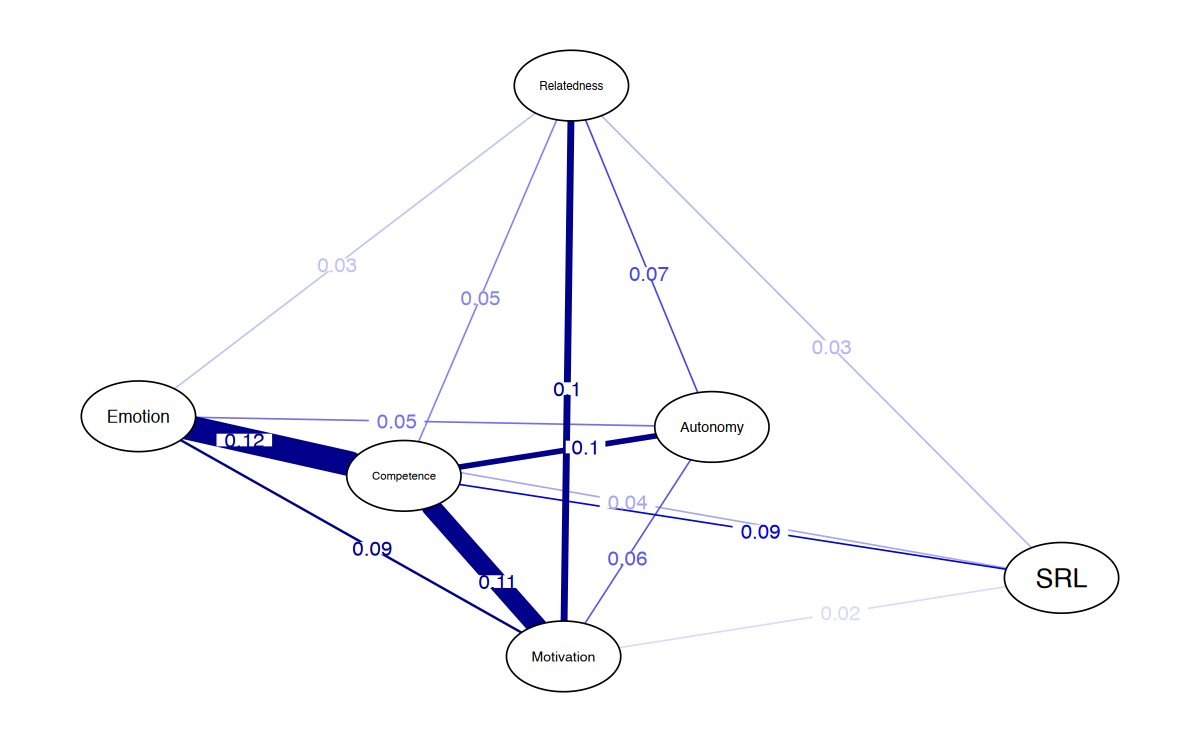

In [42]:
qgraph(edgeSDJoint,
    layout = LX, edge.labels = TRUE,
    labels = allDataPlot$Arguments$labels, vsize = 9,
    cut = 0.09, minimum = 0.01, theme = "colorblind"
)

Allo stesso modo in cui abbiamo confrontato i paesi, possiamo confrontare i generi. Come mostrato nel seguente blocco di codice, stimiamo la rete per il gruppo maschile, quella per il gruppo femminile e la rete di differenza. Le differenze risultano molto piccole o addirittura trascurabili.

Estimating Network. Using package::function:
  - qgraph::EBICglasso for EBIC model selection
    - using glasso::glasso

Warning message in EBICglassoCore(S = S, n = n, gamma = gamma, penalize.diagonal = penalize.diagonal, :
"A dense regularized network was selected (lambda < 0.1 * lambda.max). Recent work indicates a possible drop in specificity. Interpret the presence of the smallest edges with care. Setting threshold = TRUE will enforce higher specificity, at the cost of sensitivity."
Estimating Network. Using package::function:
  - qgraph::EBICglasso for EBIC model selection
    - using glasso::glasso

Warning message in EBICglassoCore(S = S, n = n, gamma = gamma, penalize.diagonal = penalize.diagonal, :
"A dense regularized network was selected (lambda < 0.1 * lambda.max). Recent work indicates a possible drop in specificity. Interpret the presence of the smallest edges with care. Setting threshold = TRUE will enforce higher specificity, at the cost of sensitivity."


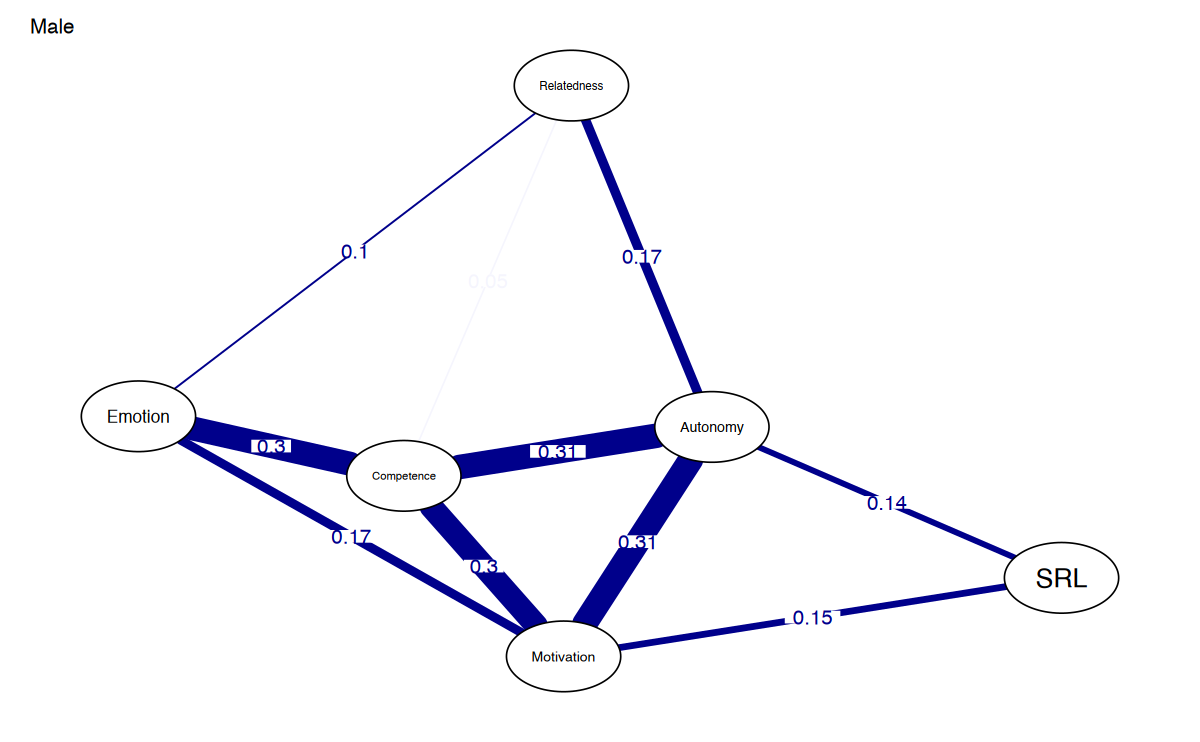

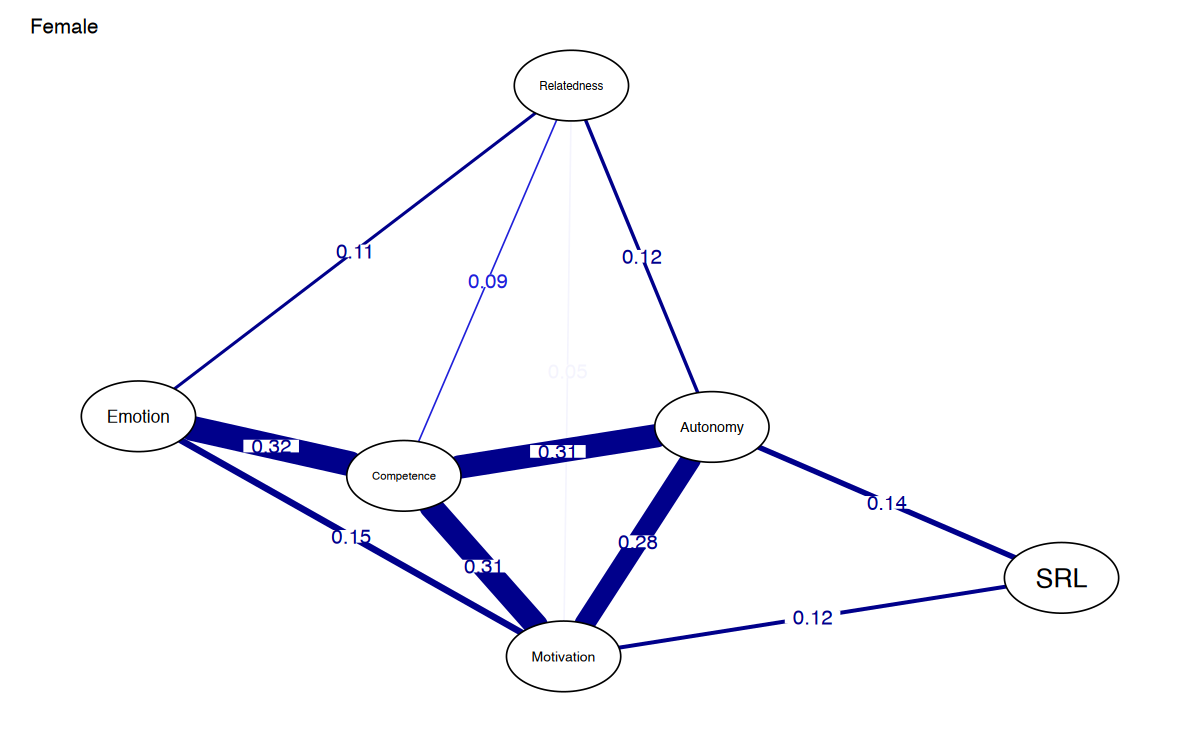

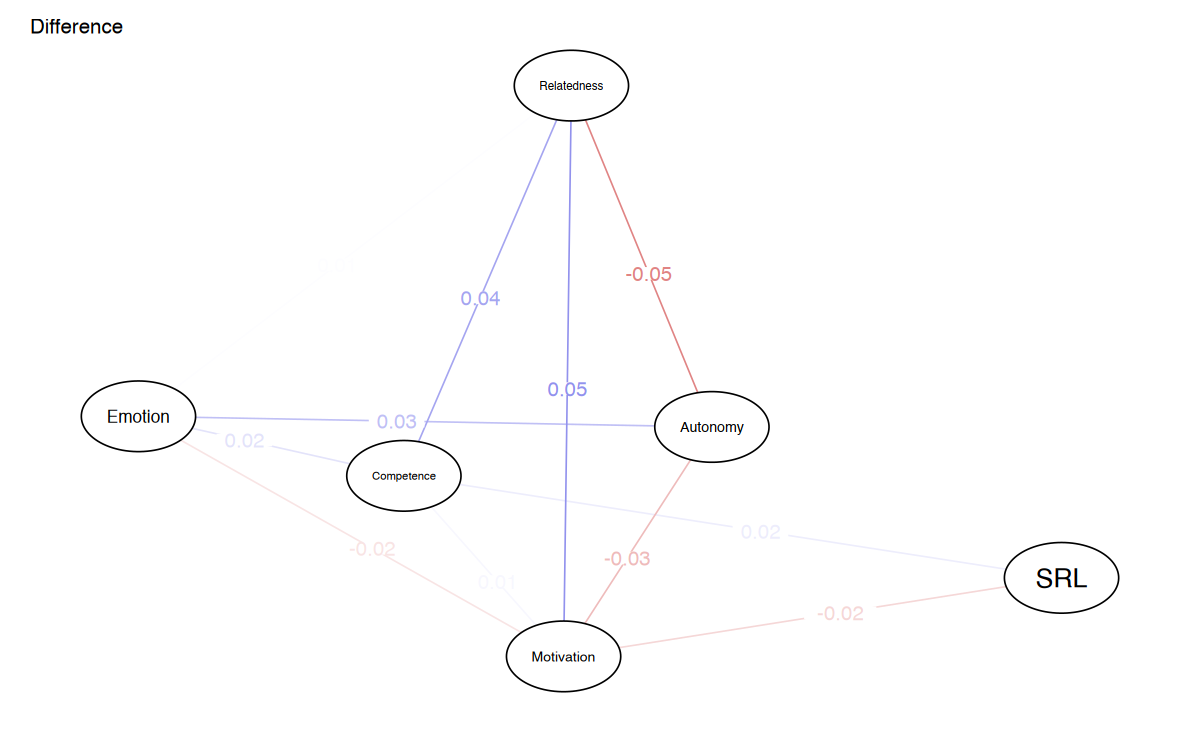

In [43]:
#| output: false
#| warning: false

maleNetwork <- estimateNetwork(maleData, default = "EBICglasso")
femaleNetwork <- estimateNetwork(femaleData, default = "EBICglasso")

plot(maleNetwork,
    title = "Male", vsize = 9, edge.labels = TRUE,
    cut = 0.10, minimum = 0.05, layout = LX
)

plot(femaleNetwork,
    title = "Female", vsize = 9,
    edge.labels = TRUE,
    cut = 0.10, minimum = 0.05, layout = LX
)

qgraph(femaleNetwork$graph - maleNetwork$graph,
    title =
        "Difference", cut = 0.1,
    labels = allDataPlot$Arguments$labels, vsize = 9,
    minimum = 0.01,
    edge.labels = TRUE, layout = LX, theme =
        "colorblind"
)

Di seguito eseguiamo il **Network Comparison Test (NCT)** e osserviamo che i valori $p$ relativi alle differenze tra tutti gli archi non sono statisticamente significativi.

In [44]:
#| output: false
#| warning: false

ComparedGender <- NCT(
maleNetwork, # network 1
femaleNetwork, # network 2
verbose = FALSE, # hide warnings and progress bar
it = 1000, # number of iterations
abs = T, # test strength or expected influence?
binary.data = FALSE, # set data distribution
test.edges = TRUE, # test edge differences
edges = 'all', # which edges to test
progressbar = FALSE) # progress bar
ComparedGender$einv.pvals # Holm-Bonferroni adjusted p-values for each edge

Warning message in EBICglassoCore(S = S, n = n, gamma = gamma, penalize.diagonal = penalize.diagonal, :
"A dense regularized network was selected (lambda < 0.1 * lambda.max). Recent work indicates a possible drop in specificity. Interpret the presence of the smallest edges with care. Setting threshold = TRUE will enforce higher specificity, at the cost of sensitivity."
Warning message in EBICglassoCore(S = S, n = n, gamma = gamma, penalize.diagonal = penalize.diagonal, :
"A dense regularized network was selected (lambda < 0.1 * lambda.max). Recent work indicates a possible drop in specificity. Interpret the presence of the smallest edges with care. Setting threshold = TRUE will enforce higher specificity, at the cost of sensitivity."
Note: Network with lowest lambda selected as best network: assumption of sparsity might be violated.

Warning message in EBICglassoCore(S = S, n = n, gamma = gamma, penalize.diagonal = penalize.diagonal, :
"A dense regularized network was selected (lambda 

,Var1,Var2,p-value,Test statistic E
,<fct>,<fct>,<dbl>,<dbl>
7,Relatedness,Competence,0.1089,0.041855
13,Relatedness,Autonomy,0.0539,0.053475
14,Competence,Autonomy,0.9940,0.000105
19,Relatedness,Emotion,0.7213,0.010878
20,Competence,Emotion,0.4276,0.019898
21,Autonomy,Emotion,0.1898,0.032293
25,Relatedness,Motivation,0.0879,0.048443
26,Competence,Motivation,0.6374,0.012712
27,Autonomy,Motivation,0.2078,0.033906


## Valutazione della Robustezza e Accuratezza

Il metodo più comune per valutare la stabilità e l'accuratezza delle reti stimate è il **bootstrapping**. Questo procedimento prevede la creazione di un grande numero di reti bootstrappate (almeno 1000) a partire dai dati originali.

**Passaggi del Bootstrapping:**

1. Si generano un numero elevato di reti bootstrappate basate sui dati originali.
2. Si calcolano i pesi degli archi per ciascuna di queste reti.
3. Si utilizzano i pesi degli archi delle reti bootstrappate per costruire intervalli di confidenza che rappresentano l'accuratezza degli archi.

**Interpretazione:**

- Per ogni arco nella rete stimata, i pesi vengono confrontati con gli intervalli di confidenza generati dalle reti bootstrappate.
- Un arco è considerato statisticamente significativo se i limiti superiore e inferiore dell’intervallo di confidenza non includono lo zero.
- Al contrario, un arco è non significativo se uno dei limiti dell’intervallo di confidenza attraversa la linea dello zero.

Questo approccio consente di identificare quali archi sono robusti e quali potrebbero essere il risultato di variabilità casuale nei dati.

In [45]:
#| output: false
#| warning: false

nCores <- parallel::detectCores() - 1
# Non-parametric bootstrap for stability of edges and of edge differences

allBoot <- bootnet(
    allNetwork, # network input
    default = "EBICglasso", # method
    nCores = nCores, # number of cores for parallelization
    computeCentrality = FALSE, # estimate centrality?
    statistics = "edge" # what statistics do we want?
)

Note: bootnet will store only the following statistics:  edge

Bootstrapping...

Computing statistics...



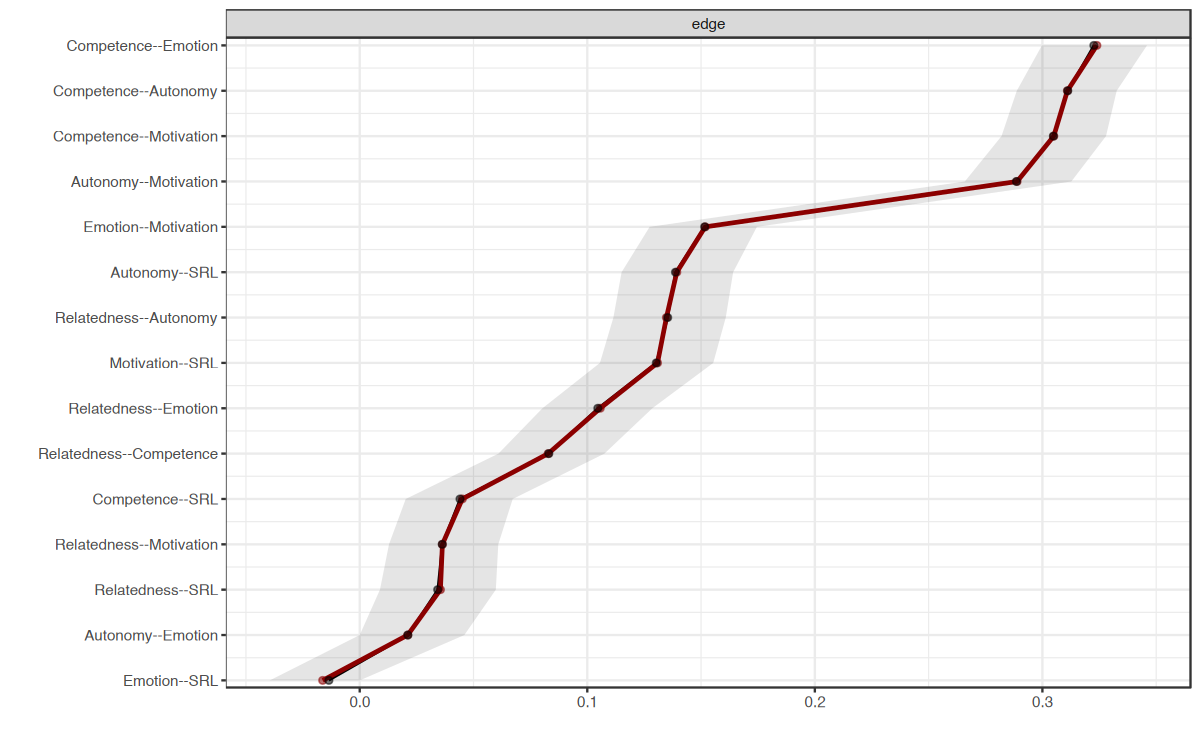

In [46]:
plot(allBoot,
    plot = "area", order = "sample", legend = FALSE
)

Come mostrato nella Figura precedente, solo gli archi **autonomy-emotion** ed **emotion-SRL** attraversano la linea dello zero e, pertanto, non sono significativi. 

Possiamo inoltre tracciare il **grafico delle differenze tra gli archi**, che verifica se i pesi degli archi differiscono significativamente tra loro. 

Expected significance level given number of bootstrap samples is approximately: 0.05



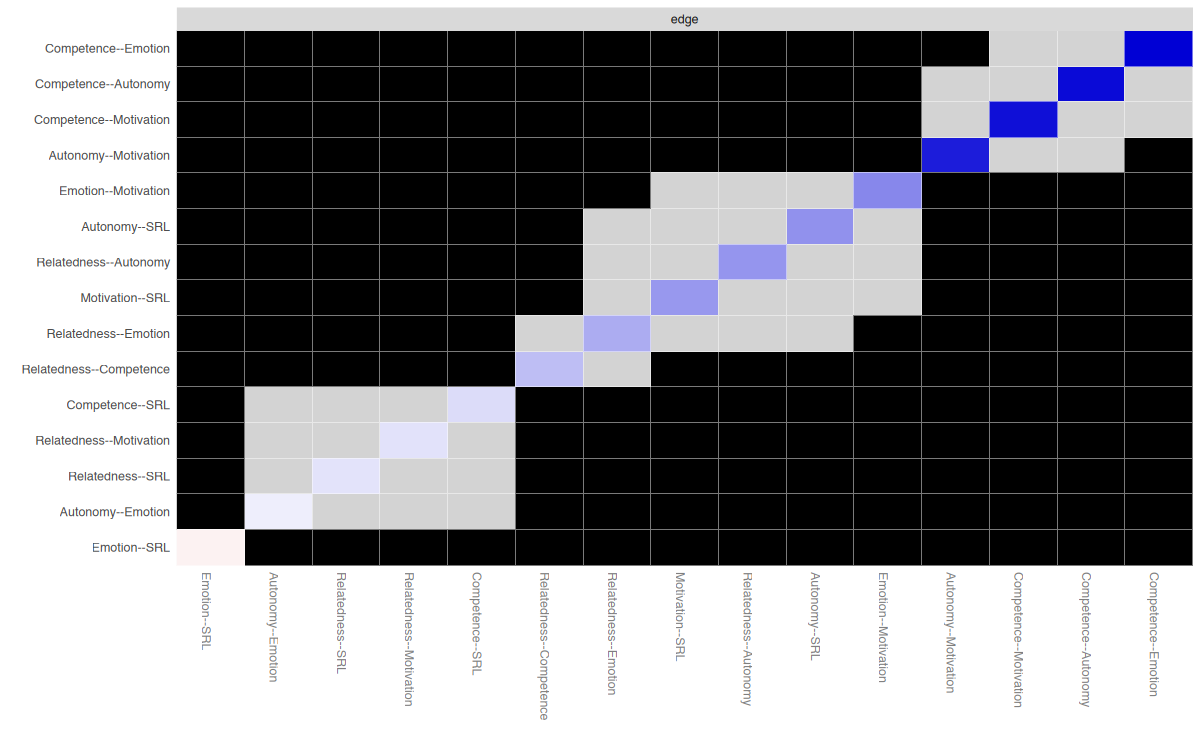

In [47]:
#| output: false
#| warning: false

plot(allBoot,
    plot = "difference", order = "sample",
    onlyNonZero = FALSE, labels = TRUE
)

**Interpretazione del Grafico delle Differenze tra gli Archi**

- **Quadrati grigi:** Indicano che l'intervallo di confidenza al 95% ottenuto dal bootstrapping per la differenza tra due archi attraversa la linea dello zero, suggerendo che la differenza non è statisticamente significativa.
- **Quadrati neri:** Indicano che l'intervallo di confidenza non attraversa lo zero, quindi la differenza tra i due archi è significativa.

Ad esempio:

- Gli archi **autonomy-emotion** ed **emotion-SRL** presentano un quadrato grigio, indicando una differenza non significativa.
- Gli archi **emotion-SRL** e **relatedness-SRL** presentano un quadrato nero, indicando che i due archi differiscono significativamente.

L'accuratezza delle misure di centralità viene valutata tramite il **case dropping test**. In questo test, vengono eliminate diverse proporzioni di casi dai dati, e si calcola la correlazione tra la misura di centralità osservata e quella ottenuta dai dati ridotti. Se la correlazione diminuisce significativamente dopo l'eliminazione di un piccolo sottoinsieme di casi, la misura di centralità è considerata **non affidabile**.

In [48]:
#| output: false
#| warning: false

set.seed(1)
centBoot <- bootnet(
    allNetwork, # network input
    default = "EBICglasso", # method
    type = "case", # method for testing centrality stability
    nCores = nCores, # number of cores
    computeCentrality = TRUE, # compute centrality
    statistics = c("strength", "expectedInfluence"),
    nBoots = 19000, # number of bootstraps
    caseMin = .05, # min cases to drop
    caseMax = .95 # max cases to drop
)

Note: bootnet will store only the following statistics:  strength, expectedInfluence

Bootstrapping...

Computing statistics...



Il **coefficiente di stabilità della correlazione** è una metrica utilizzata per valutare la stabilità delle misure di centralità attraverso il **case dropping test**. Esso viene stimato come la massima proporzione di casi che può essere eliminata mantenendo una correlazione di almeno 0.7 con il campione originale.

In [49]:
corStability(centBoot)

=== Correlation Stability Analysis === 

Sampling levels tested:
   nPerson Drop%    n
1      358    95 1954
2     1074    85 1918
3     1790    75 1865
4     2506    65 1928
5     3222    55 1826
6     3938    45 1939
7     4654    35 1891
8     5370    25 1930
9     6086    15 1927
10    6802     5 1822

Maximum drop proportions to retain correlation of 0.7 in at least 95% of the samples:

expectedInfluence: 0.95 (CS-coefficient is highest level tested)
  - For more accuracy, run bootnet(..., caseMin = 0.85, caseMax = 1) 

strength: 0.95 (CS-coefficient is highest level tested)
  - For more accuracy, run bootnet(..., caseMin = 0.85, caseMax = 1) 

Accuracy can also be increased by increasing both 'nBoots' and 'caseN'.

Se tracciamo i risultati, possiamo osservare che il **coefficiente di stabilità della correlazione** è pari a 0.95, un valore molto elevato che indica un'alta stabilità degli archi.

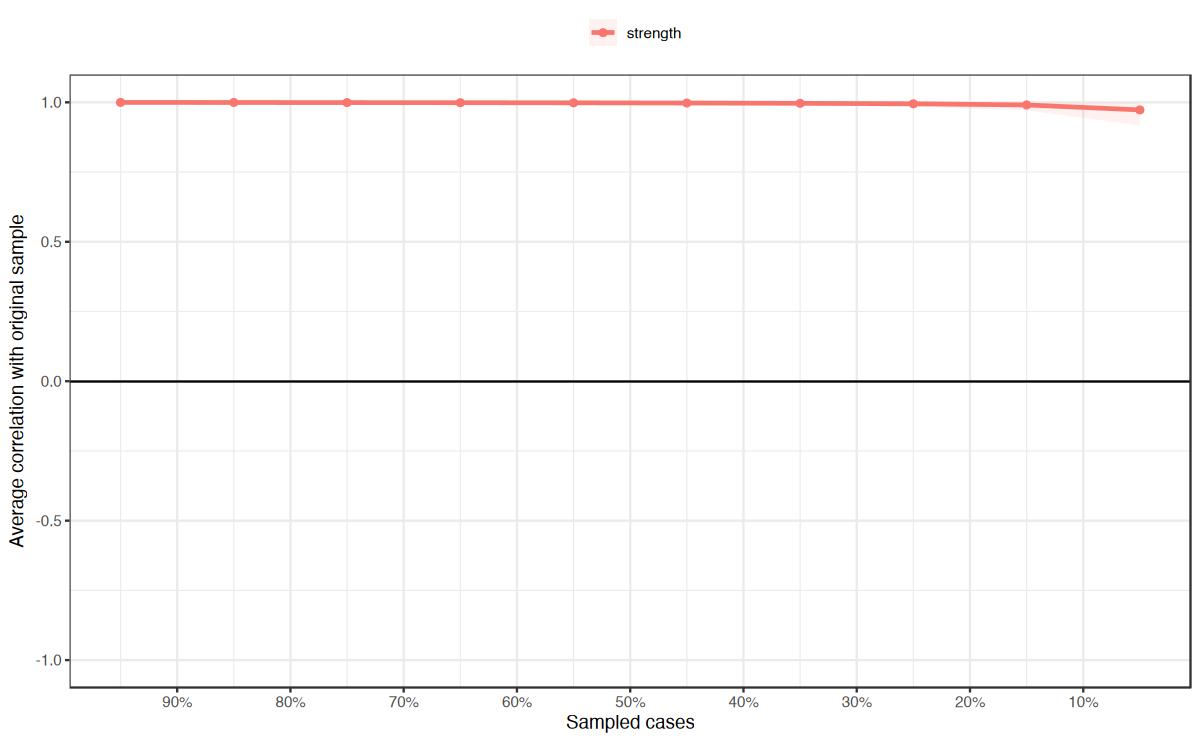

In [50]:
plot(centBoot)

## Riflessioni Conclusive

Il campo delle reti psicologiche è in rapida espansione, con metodi che vengono continuamente perfezionati. In questo capitolo, abbiamo illustrato i passaggi fondamentali per analizzare una rete psicologica, visualizzarne i risultati e confrontare diverse reti. Inoltre, abbiamo mostrato come utilizzare metodi statistici robusti per il confronto delle reti e come testare l'accuratezza delle reti stimate attraverso il bootstrapping.

Un’importante questione è il confronto tra le reti psicologiche e altri metodi utilizzati nel campo educativo, come l'**Epistemic Network Analysis (ENA)**. ENA, ad esempio:

- Non offre strumenti per testare se i pesi degli archi sono significativamente diversi dal caso.
- Non include metodi rigorosi per confrontare le reti o verificare i pesi degli archi.
- Non prevede misure di centralità o altre metriche tipiche delle reti.

Di fatto, l'**Epistemic Network Analysis (ENA)** non ha una connessione diretta con i metodi propri dell'analisi delle reti. Strumenti fondamentali come la verifica casuale o il calcolo delle metriche di rete non possono essere applicati. Analogamente, il **process mining**, che genera reti di transizione, presenta limitazioni significative, offrendo pochi test statistici per confermare la validità dei modelli generati o per confrontarli in modo rigoroso con altri modelli.

L'**analisi delle reti sociali (SNA)** è forse il metodo più vicino alle reti psicologiche. Tuttavia, SNA si limita solitamente a tipi specifici di archi (come co-occorrenze, risposte o interazioni) che sono quasi sempre **non direzionati** e **positivi**, concentrandosi principalmente su interazioni sociali o semantiche.

**Vantaggi delle Reti Psicologiche**

Le reti psicologiche offrono una prospettiva molto più ampia sulle interazioni e le dipendenze tra le variabili, grazie a un vasto numero di metodi di stima e tecniche di ottimizzazione disponibili. Inoltre, il campo è supportato da una comunità scientifica dinamica che continua a migliorare e innovare i metodi esistenti. 

Un altro punto di forza è che le reti psicologiche **non richiedono una teoria preesistente o forti assunzioni** sulle variabili modellate, rendendole strumenti analitici flessibili e potenti. Come affermato da Borsboom et al., le reti psicologiche "formano un ponte naturale tra l'analisi dei dati e la formazione di teorie basate sui principi della scienza delle reti" e possono quindi essere utilizzate per "generare ipotesi causali".

In conclusione, le reti psicologiche si dimostrano uno strumento potente e versatile per l'analisi dei sistemi complessi, offrendo nuovi modi di esplorare le interazioni tra variabili psicologiche e generare nuove ipotesi teoriche. 

**Risorse Raccomandate**

1. Epskamp, S., Borsboom, D., & Fried, E. I. (2018). Estimating psychological networks and their accuracy: A tutorial paper. *Behavior Research Methods, 50*(1), 195–212. https://doi.org/10.3758/s13428-017-0862-1  

2. Epskamp, S., & Fried, E. I. (2018). A tutorial on regularized partial correlation networks. *Psychological Methods, 23*(4), 617–634. https://doi.org/10.1037/met0000167  

3. Van Borkulo, C. D., Van Bork, R., Boschloo, L., Kossakowski, J. J., Tio, P., Schoevers, R. A., & Waldorp, L. J. (2022). Comparing network structures on three aspects: A permutation test. *Psychological Methods.* https://doi.org/10.1037/met0000427  

4. Borsboom, D., Deserno, M. K., Rhemtulla, M., Epskamp, S., Fried, E. I., McNally, R. J., & Waldorp, L. J. (2021). Network analysis of multivariate data in psychological science. *Nature Reviews Methods Primers, 1*(1), 58. https://doi.org/10.1038/s43586-021-00055-w  

5. Bringmann, L. F., Elmer, T., Epskamp, S., Krause, R. W., Schoch, D., Wichers, M., & Snippe, E. (2019). What do centrality measures measure in psychological networks? *Journal of Abnormal Psychology, 128*(8), 892–903. https://doi.org/10.1037/abn0000446  

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [51]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: aarch64-apple-darwin20
Running under: macOS Sequoia 15.1.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] C

time zone: Europe/Rome
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] matrixcalc_1.0-6            mgm_1.2-14                 
 [3] qgraph_1.9.8                NetworkComparisonTest_2.2.2
 [5] NetworkToolbox_1.4.2        networktools_1.5.2         
 [7] bootnet_1.6                 rio_1.2.3                  
 [9] MASS_7.3-61                 viridis_0.6.5              
[11] viridisLite_0.4.2           ggpubr_0.6.0               
[13] ggExtra_0.10.1              gridExtra_2.3              
[15] patchwork_1.3.0             bayesplot_1.11.1       